### student_ID_1 = 011996279
### student_ID_2 = 207576463

# Imports

In [38]:
from keras.datasets import mnist
import random
import math
import numpy as np
import pandas as pd
from itertools import combinations, product
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, pairwise_distances, completeness_score, homogeneity_score, classification_report, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
# from sklearn.manifold import TSNE
from openTSNE import TSNE # used this since sklearn TSNE has no transform method 
import umap # may need to pip install umap-learn 
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

random.seed(11996279)

# Utils

In [5]:
# Function to calculate the percentage of total that each class / label / digit represents 
def calc_class_percentage(num_classes, labels):
    total_len = len(labels)
    for i in range(num_classes):
        class_samples = len(np.where(labels == i)[0])
        class_percentage = class_samples / total_len
        print(f'class {i} is {100 * class_percentage:.2f}% of the data')

##### Clustering Viz Utils:

In [3]:
# Function to visualize the clusters 
def visualize_clusters(X, labels):
    for cluster in np.unique(labels):
        if cluster == -1:
            continue  # Ignore noise points in DBSCAN
        cluster_mask = labels == cluster
        images = X[cluster_mask][:9]
        plt.figure()
        plt.suptitle(f"Cluster {cluster}")
        for i in range(min(9, images.shape[0])):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].reshape(28, 28), cmap="gray")
            plt.axis("off")
        plt.show()

In [2]:
# Function to evaluate clustering with confusion matrix and purity measure 
def evaluate(y_true, y_clusters): # not used in the end
    cm = np.zeros((np.max(y_true)+1, np.max(y_clusters)+1))
    for i in range(y_true.size):
        cm[y_true[i], y_clusters[i]]+=1
    plt.imshow(cm, interpolation='none', cmap=plt.cm.Blues)
    plt.ylabel('Class Labels')
    plt.xlabel('Clusters')
    plt.title('Clustering Confusion Matrix', fontsize=16)
    plt.show()
    purity = 0.
    for cluster in range(cm.shape[1]):  # clusters are along columns
        purity += np.max(cm[:, cluster])
    purity_score = purity / y_true.size
    print (f'Purity of Clusters = {purity_score:.2f}')
    # return purity/y_true.size

def purity_score(y_true, y_pred): # from https://stackoverflow.com/a/51672699/7947996; in [0,1]; 0-bad,1-good
    # compute contingency matrix (also called confusion matrix)
    conting_mx = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(conting_mx, axis=0)) / np.sum(conting_mx)


#### Dimensionality Reduction Viz Utils:

In [24]:
# Function to visualize the first few features in the new space (after employing dimensionality reduction algorithms)
def visualize_reduced_data(X_reduced, y, name):
    plt.figure(figsize=(8,6))
    for label in np.unique(y):
        mask = y == label
        plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], label=label, s = 2)
    plt.xlabel('New Reduced Space: Feature 1', fontsize=12)
    plt.ylabel('New Reduced Space: Feature 2', fontsize=12)
    plt.title(f'Visualizing Features in New Space After Dimensionality Reduction with {name}')
    plt.legend()
    plt.show()


# Function to visualize classification accuracy vs. hyperparams for dim redux algorithms
def dim_tuning(df, alg_name):
    x_vals = [val[0] for val in df.loc[:, 'params'].values]
    y_vals = df.loc[:, 'Accuracy']
    fig = plt.figure(figsize = (7,5))
    plt.plot(x_vals, y_vals)
    plt.title(f'Classifier Accuracy vs. Dim Redux Params for {alg_name}', fontsize=16 )
    plt.ylabel('Classifier Accuracy', fontsize=12)
    plt.xlabel('perplexity' if alg_name == 't-SNE' else 'n_components', fontsize=12)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # these two lines were just to clean up axes number formats
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}')) 
    plt.grid()
    plt.show()
    
# Function to visualize explained variance of new features / components for PCA & TruncatedSVD
def dim_var(alg_class, alg_name):
    fig = plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,11), alg_class.explained_variance_ratio_, label='Component Var')
    plt.plot(np.arange(1,11), np.cumsum(alg_class.explained_variance_ratio_), label='Cumulative Var')
    plt.title(f'Component-wise and Cumulative Explained Variance for {alg_name} Dim Redux', fontsize=16)
    plt.grid()
    plt.ylabel('Explained Variance', fontsize=12)
    plt.xlabel('Component in Reduced Space', fontsize=12)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # these two lines were just to clean up axes number formats
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}')) 
    plt.legend()
    plt.show()

## Part 0: Load the data
1) Load the MNIST dataset.
2) Explore the data briefly

In [6]:
# we are using the Keras library to load the MNIST dataset. The dataset is divided into training and testing sets. 
# We flatten the images to convert each 28x28 image into a single row with 784 features (pixels). 
# Finally, we normalize the pixel values to the range [0, 1].

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the images
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Normalize the pixel values
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255


#### Data Exploration & Characterizations:

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


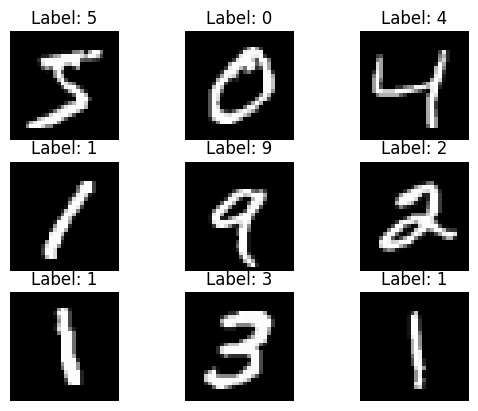

In [7]:
# 2) Explore the data briefly

# Print the shapes of the data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Visualize some samples from the dataset
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.show()

#### Visualizing Distribution of Digits in the Data

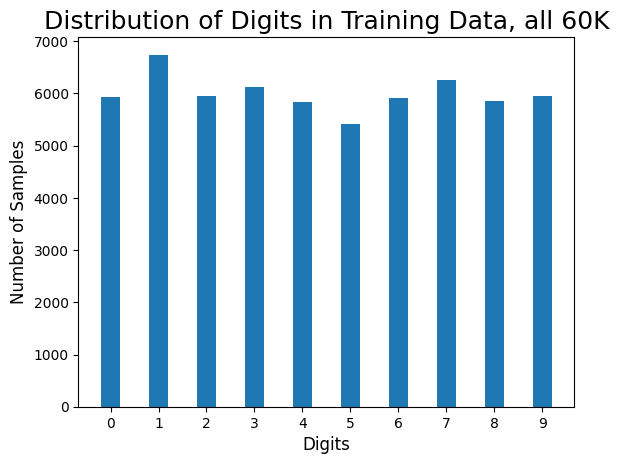

In [8]:
bins = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2, 4.8, 5.2, 5.8, 6.2, 6.8, 7.2, 7.8, 8.2, 8.8, 9.2]
plt.hist(y_train, bins = bins)
plt.xlabel('Digits', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(np.arange(10))
plt.title('Distribution of Digits in Training Data, all 60K', fontsize=18)
plt.show()

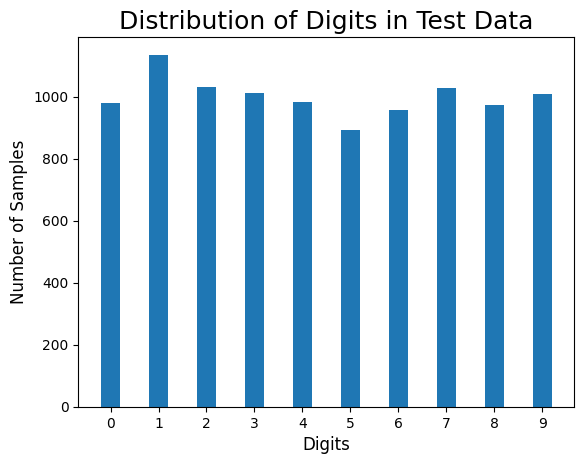

In [9]:
plt.hist(y_test, bins = bins)
plt.xlabel('Digits', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(np.arange(10))
plt.title('Distribution of Digits in Test Data', fontsize=18)
plt.show()

In [10]:
calc_class_percentage(10, y_train)

class 0 is 9.87% of the data
class 1 is 11.24% of the data
class 2 is 9.93% of the data
class 3 is 10.22% of the data
class 4 is 9.74% of the data
class 5 is 9.04% of the data
class 6 is 9.86% of the data
class 7 is 10.44% of the data
class 8 is 9.75% of the data
class 9 is 9.92% of the data


#### Data Normalization 
**Note:** We tried this as normalizing is usually additive to performance, but it didn't help at all so we didn't end up using it

In [11]:
scaler = MinMaxScaler()
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_test = scaler.transform(X_test)


### Subsampling
**Note:** We subsampled 10K of the 60K initial training set, as some degree of dataset shrinkage was required to get the notebook to run without crashing or running for many hours (particularly the clustering and dim redux algorithms). We experimented with 5K and 20K subsamples as well, but ultimately found 10K to strike the best balance of making the dataset usable, while preserving robustness. 

In [12]:
n = 10000

selected_indices = random.sample(range(len(y_train)), n)
partial_X_train = X_train[selected_indices]
partial_y_train = y_train[selected_indices]
# calc_class_percentage(10, partial_y_train)

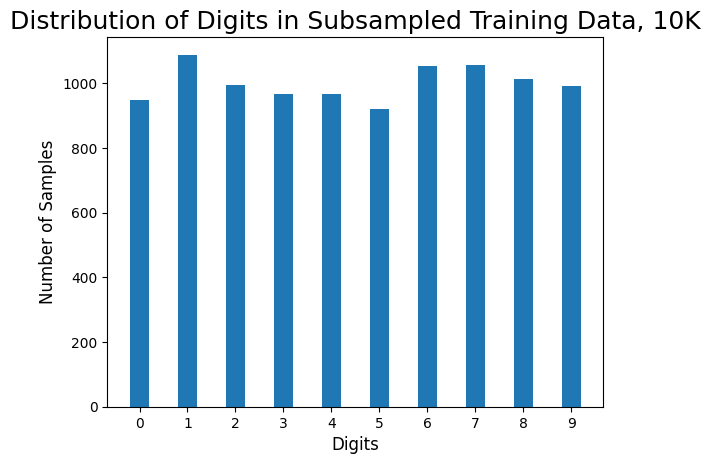

Updated Class Percentages for Subsampled Data: 

class 0 is 9.47% of the data
class 1 is 10.88% of the data
class 2 is 9.94% of the data
class 3 is 9.67% of the data
class 4 is 9.68% of the data
class 5 is 9.21% of the data
class 6 is 10.54% of the data
class 7 is 10.56% of the data
class 8 is 10.13% of the data
class 9 is 9.92% of the data


In [13]:
plt.hist(partial_y_train, bins = bins)
plt.xlabel('Digits', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(np.arange(10))
plt.title('Distribution of Digits in Subsampled Training Data, 10K', fontsize=18)
plt.show()

print('Updated Class Percentages for Subsampled Data: \n') 
calc_class_percentage(10, partial_y_train)

## Part 1: Clustering
3) For at least three different clustering methods of your choice perform:

*   a) Cluster the data using the raw pixel level values.

*   b) Evaluate the clustering result using standard evaluation metrics

*   c) Visualize the clusters by displaying a few images from each cluster.
*  d) Build a simple classifier based on the clustering results. Specifically, assign a label to each
cluster (e.g., the most common digit in the cluster) and use this label to predict the digit of
a test image based on its nearest cluster.
Note: You may suggest other methods to construct a classifier over the clustering results.


*  e) Evaluate the performance of the classifier.
*  f) Explore different parameters for the clustering and evaluate their effect on the results


#### Clustering Algorithms: K-Means, DBSCAN, Agglomerative, and Birch


DBSCAN Clustering Evaluation & Visualization:


params,Silhouette Score,Adjusted Rand Index,Completeness Score,Homogeneity Score,Accuracy
"(5, 0.1)",-0.156944,0.061169,0.624452,0.239003,0.331500
"(5, 0.125)",-0.118196,0.125023,0.606538,0.348387,0.432200
"(5, 0.15)",-0.133251,0.147247,0.498128,0.270190,0.262000
"(10, 0.1)",-0.082568,0.047627,0.700946,0.170252,0.261000
"(10, 0.125)",-0.051469,0.094663,0.652223,0.288928,0.386000
"(10, 0.15)",-0.032849,0.131824,0.523485,0.239416,0.278700


Purity of Clusters Generated by DBSCAN Clustering: 0.30



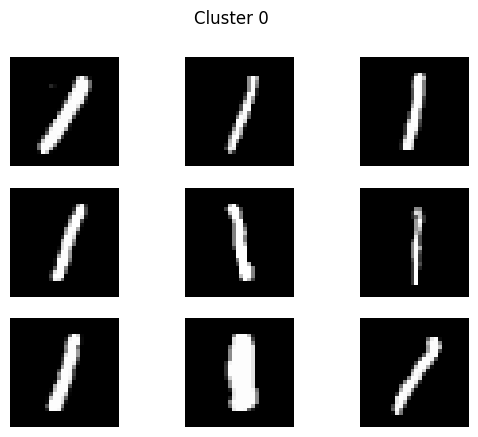

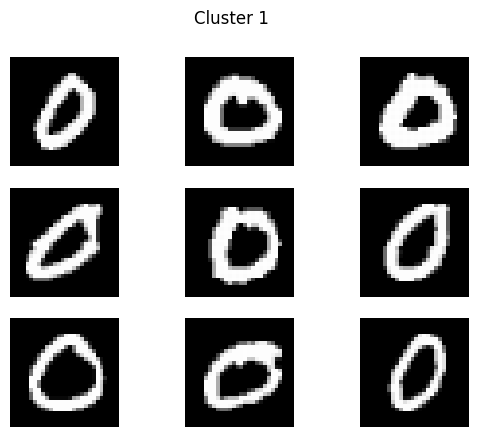

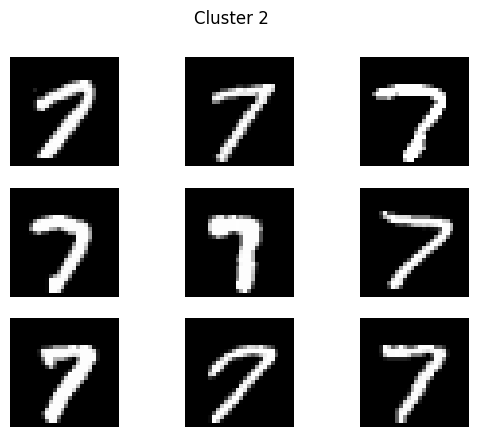

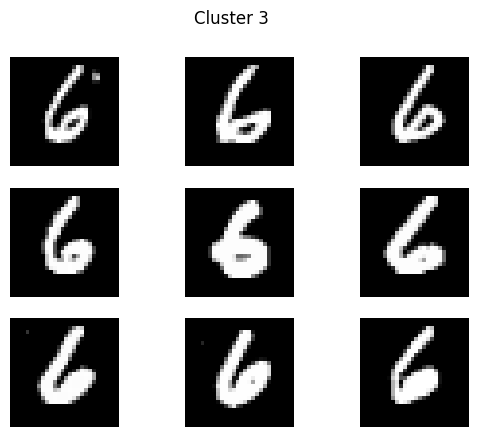

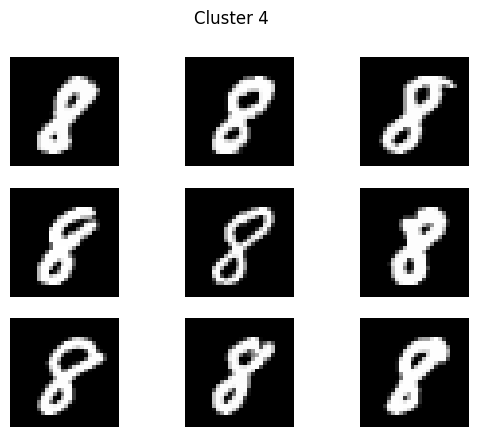

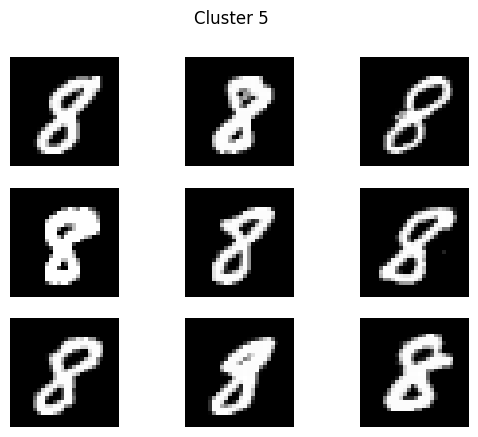

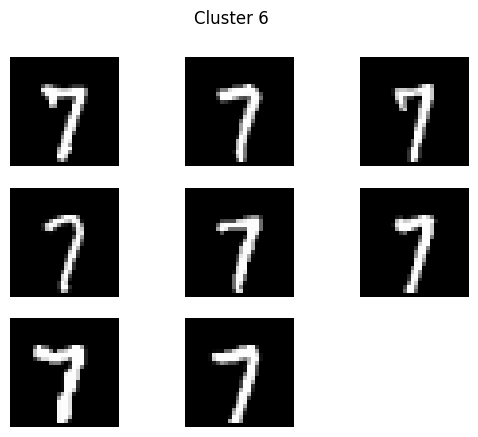

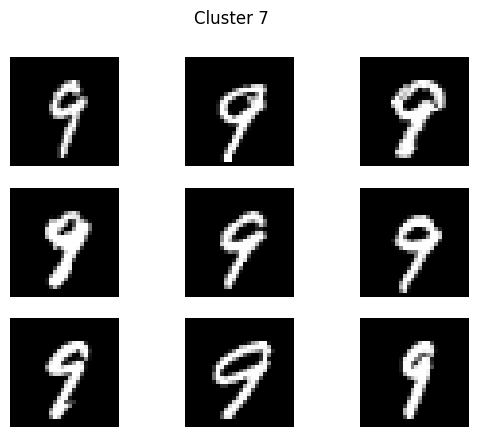

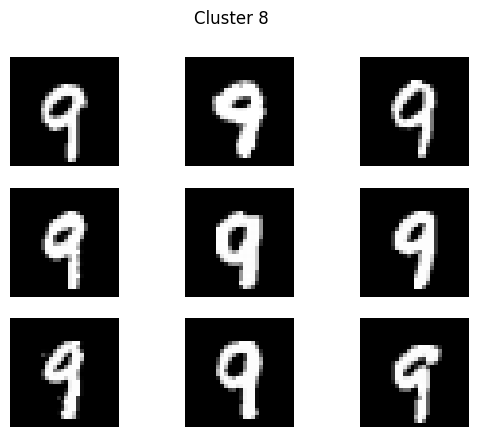

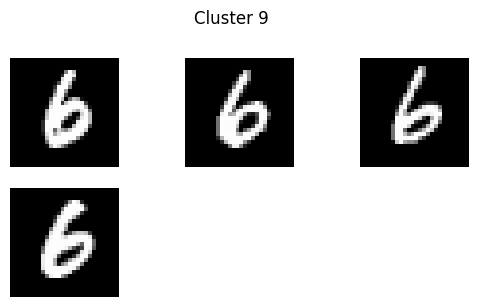

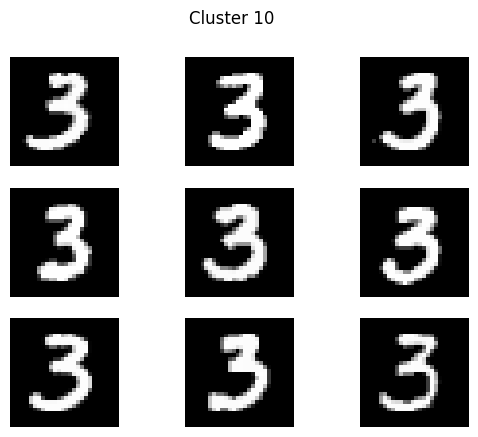

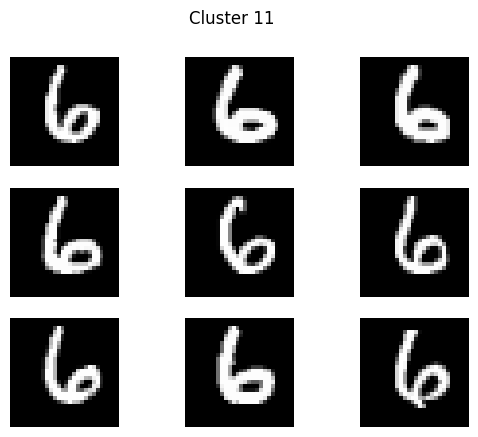

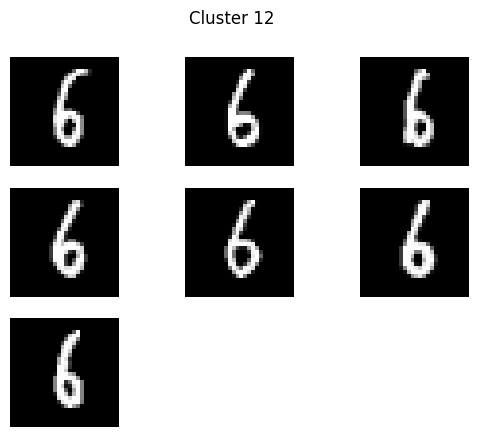

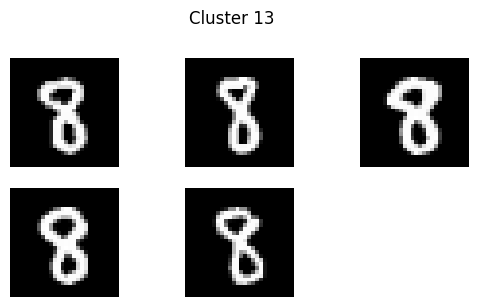

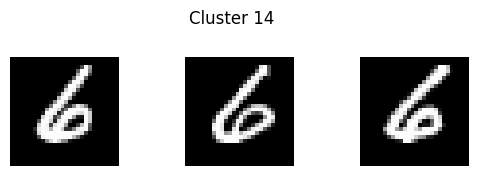

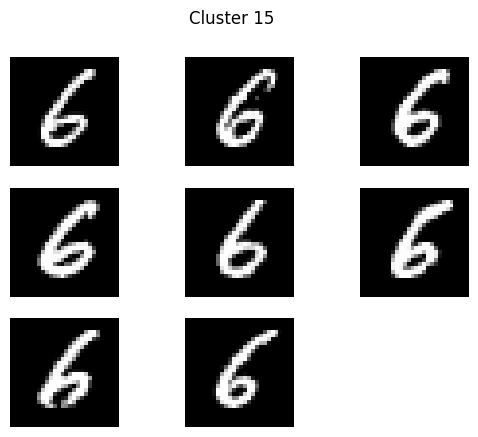

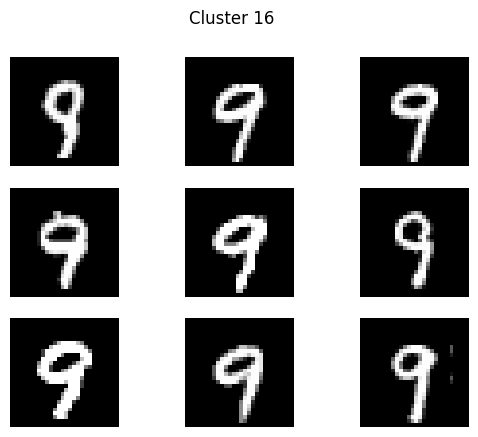

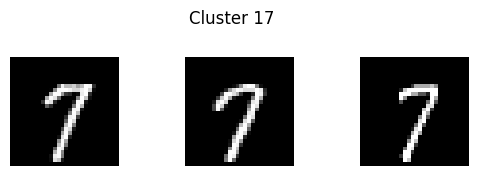

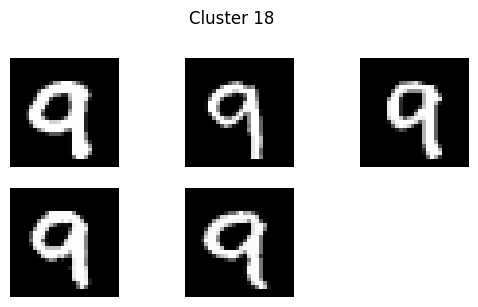

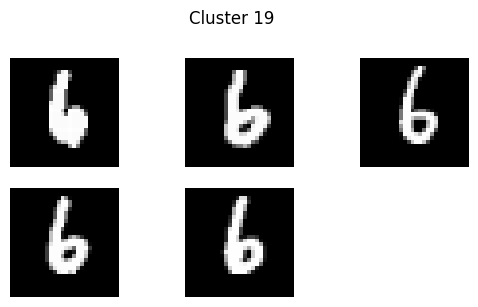

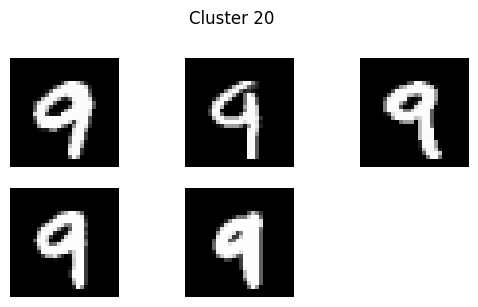

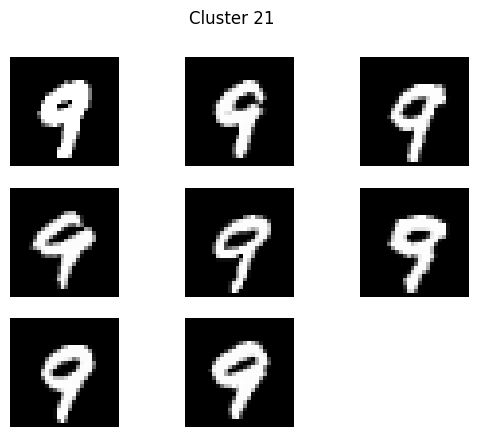

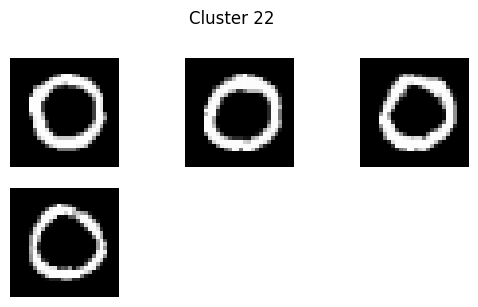

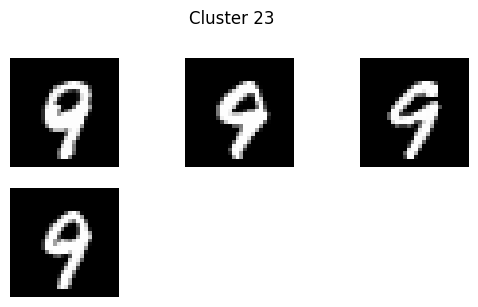

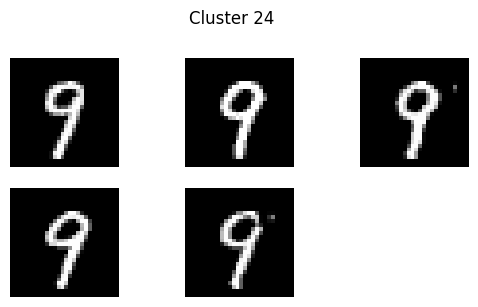

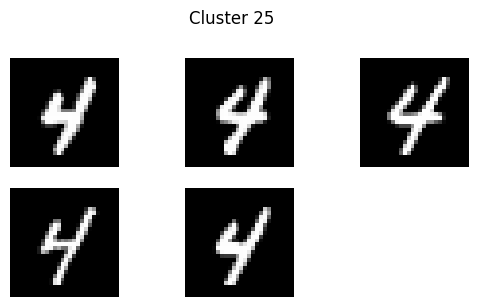

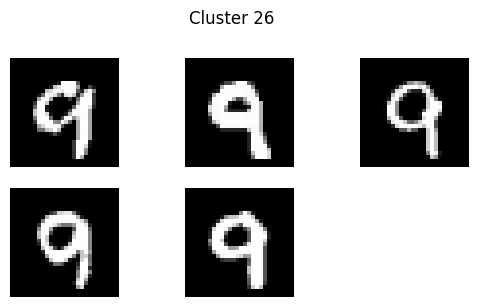

KMeans Clustering Evaluation & Visualization:


params,Silhouette Score,Adjusted Rand Index,Completeness Score,Homogeneity Score,Accuracy
"('lloyd', 'k-means++')",0.055792,0.360438,0.487726,0.484874,0.603600
"('lloyd', 'random')",0.055721,0.362322,0.488488,0.485862,0.602500
"('elkan', 'k-means++')",0.055792,0.360438,0.487726,0.484874,0.603600
"('elkan', 'random')",0.055721,0.362322,0.488488,0.485862,0.602500


Purity of Clusters Generated by KMeans Clustering: 0.60



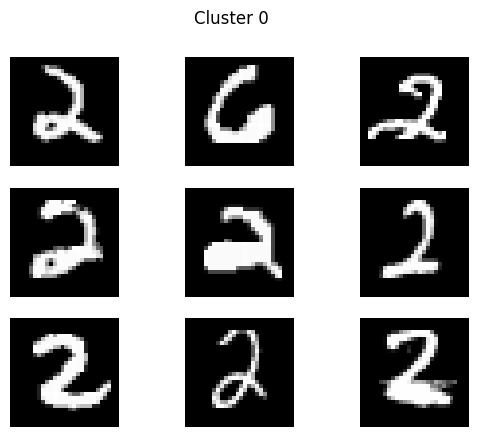

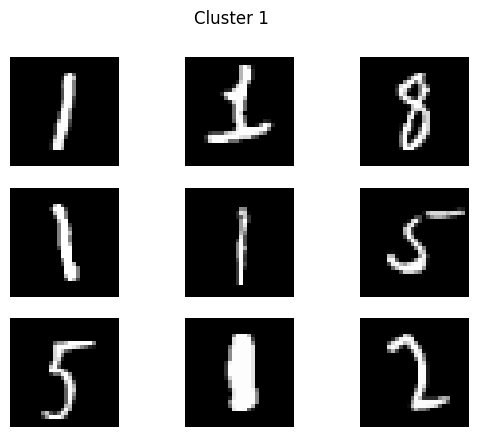

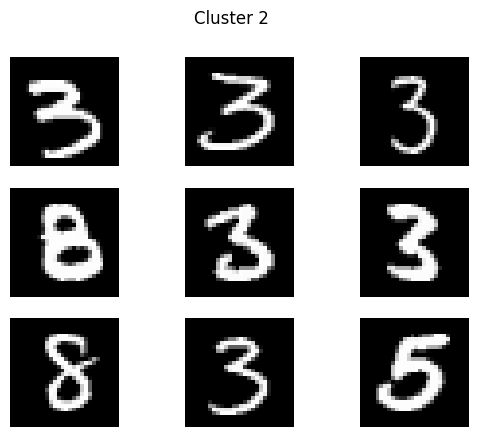

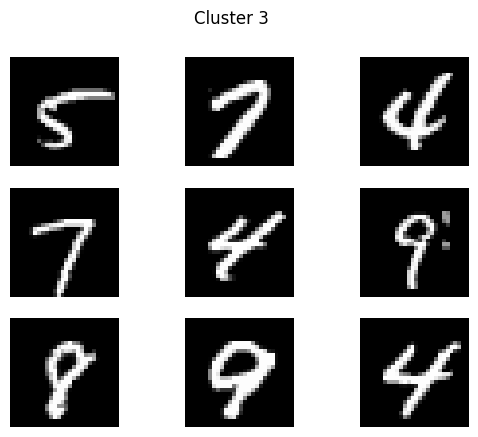

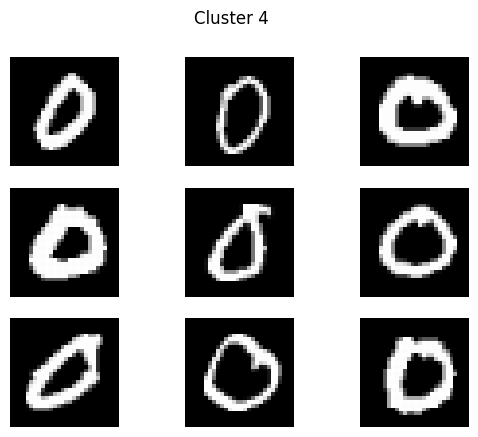

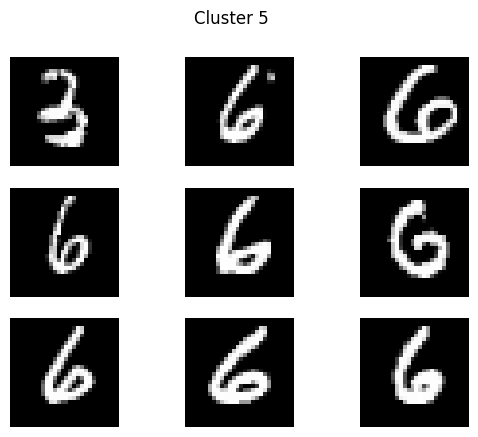

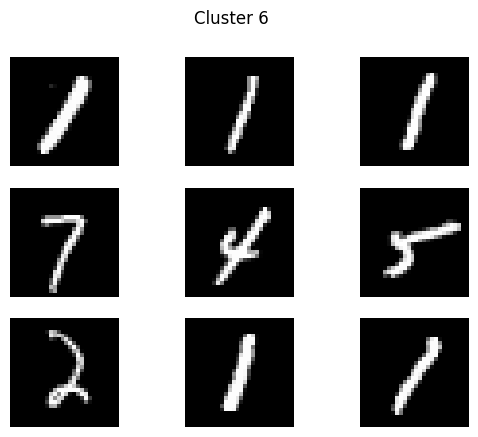

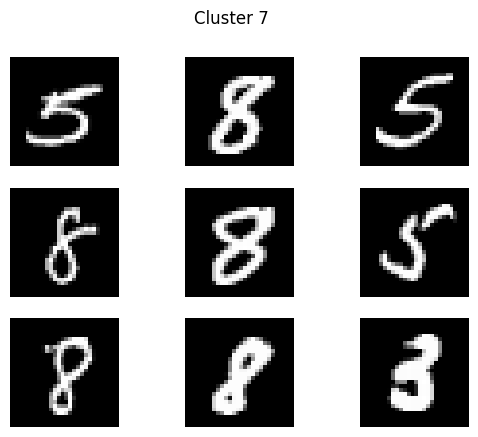

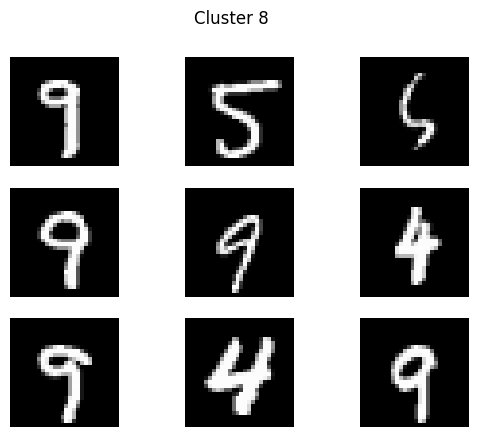

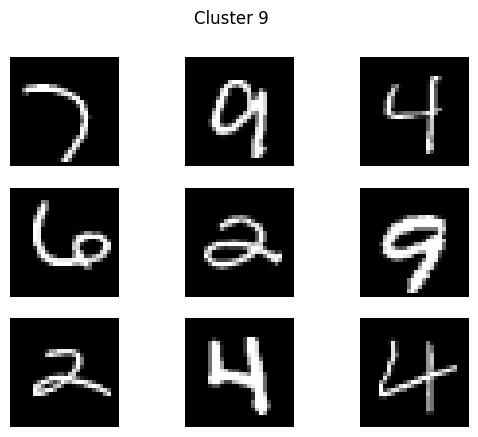

Agglomerative Clustering Evaluation & Visualization:


params,Silhouette Score,Adjusted Rand Index,Completeness Score,Homogeneity Score,Accuracy
"('ward', 'euclidean')",0.033797,0.483780,0.684484,0.650964,0.668100
"('complete', 'euclidean')",0.038485,0.235407,0.476231,0.372799,0.463000
"('complete', 'manhattan')",0.021180,0.171984,0.373007,0.308758,0.425700
"('complete', 'cosine')",0.005710,0.160314,0.300741,0.281871,0.341800


Purity of Clusters Generated by Agglomerative Clustering: 0.36



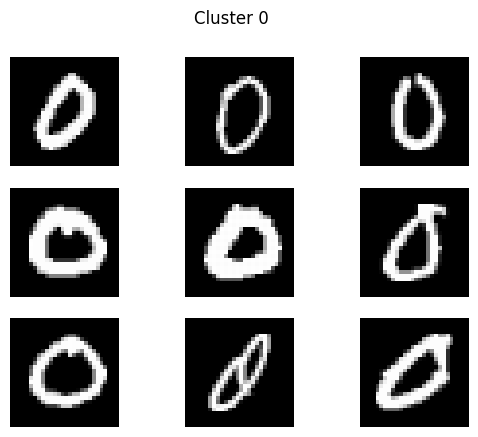

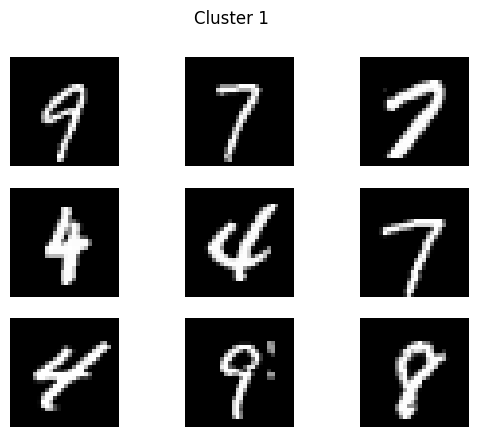

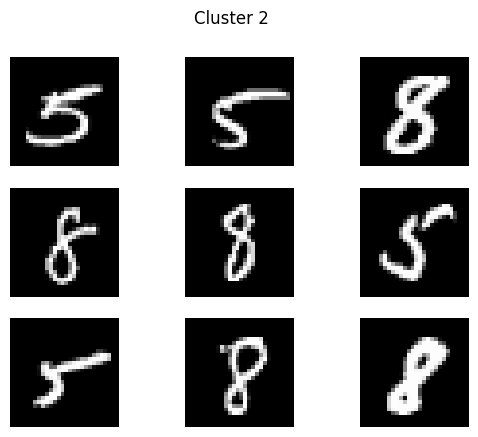

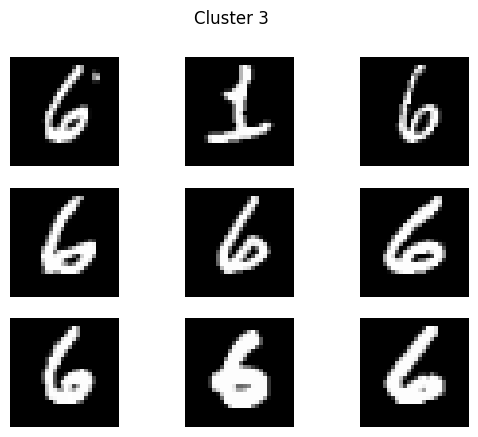

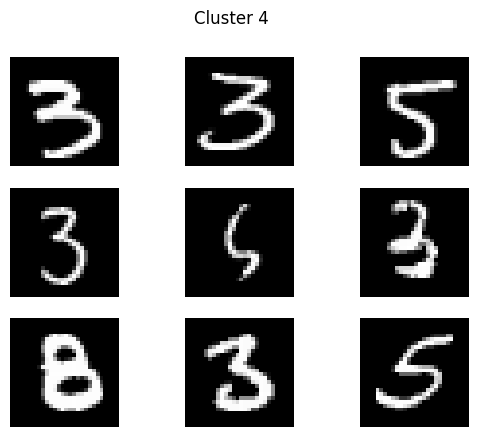

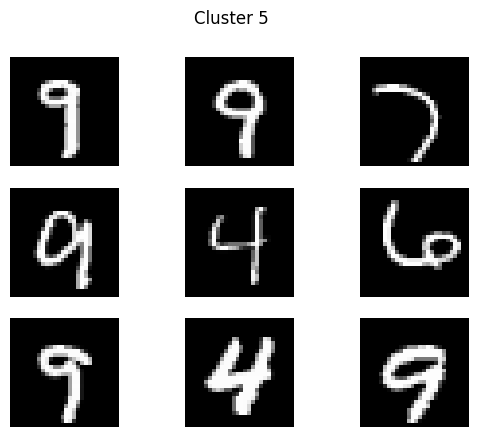

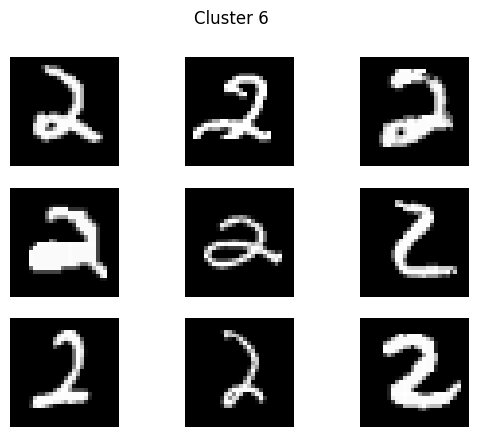

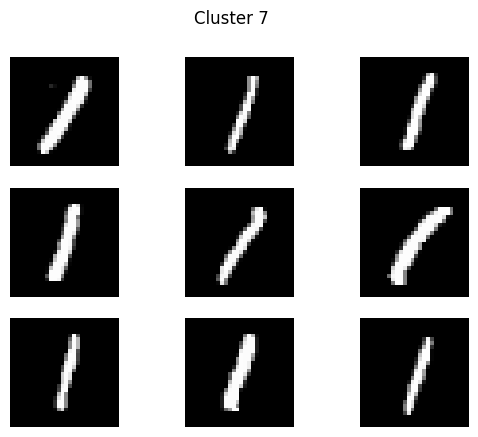

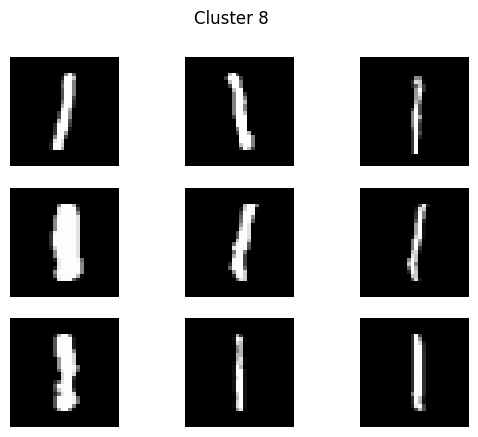

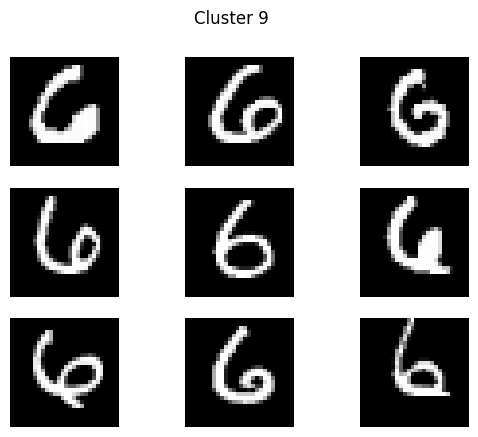

Birch Clustering Evaluation & Visualization:


params,Silhouette Score,Adjusted Rand Index,Completeness Score,Homogeneity Score,Accuracy
"(0.3, 40)",0.033797,0.483780,0.684484,0.650964,0.668100
"(0.3, 60)",0.033797,0.483780,0.684484,0.650964,0.668100
"(0.5, 40)",0.033797,0.483780,0.684484,0.650964,0.668100
"(0.5, 60)",0.033797,0.483780,0.684484,0.650964,0.668100
"(0.7, 40)",0.033924,0.484606,0.685981,0.651983,0.668500
"(0.7, 60)",0.029970,0.555658,0.710409,0.684520,0.713600


Purity of Clusters Generated by Birch Clustering: 0.71



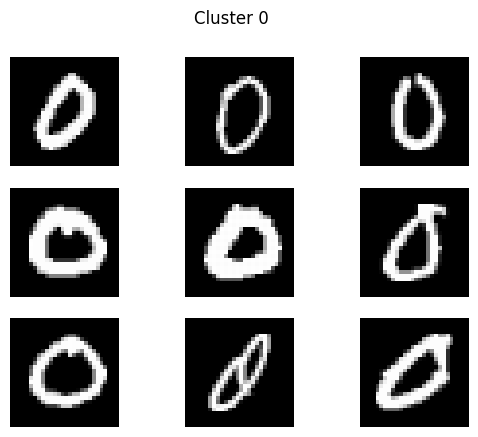

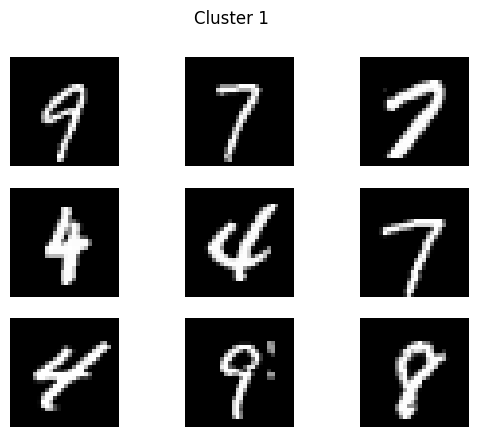

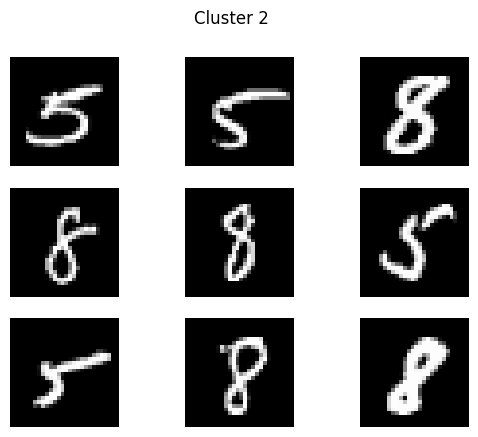

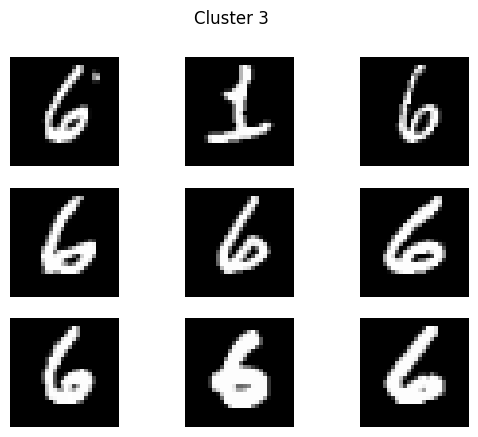

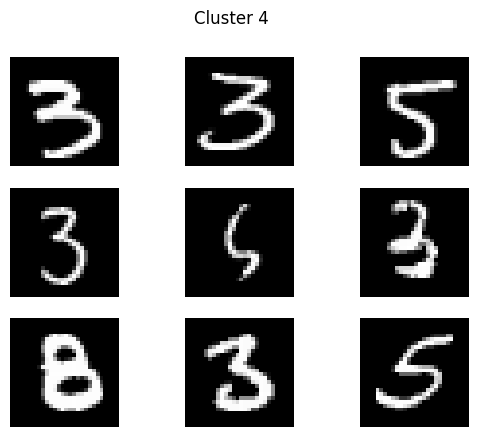

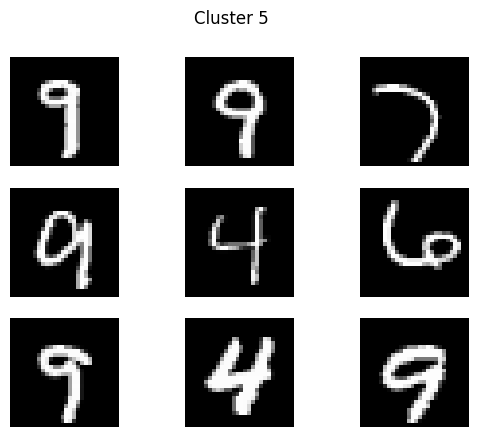

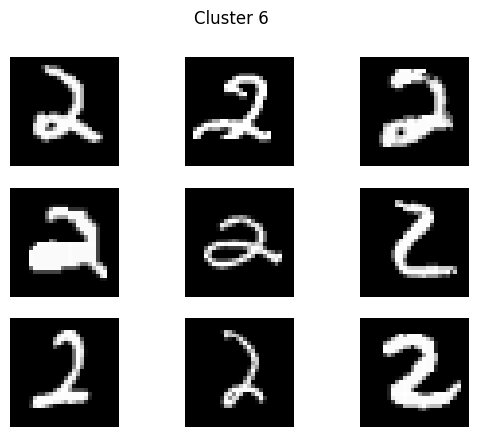

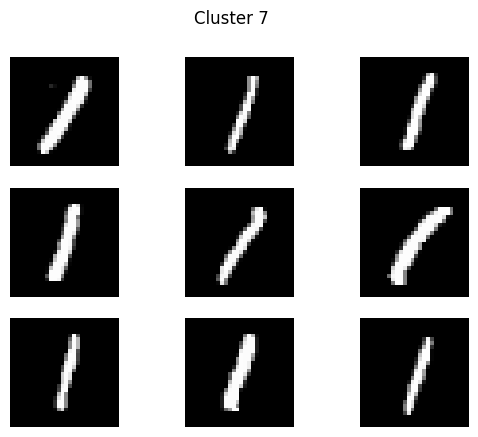

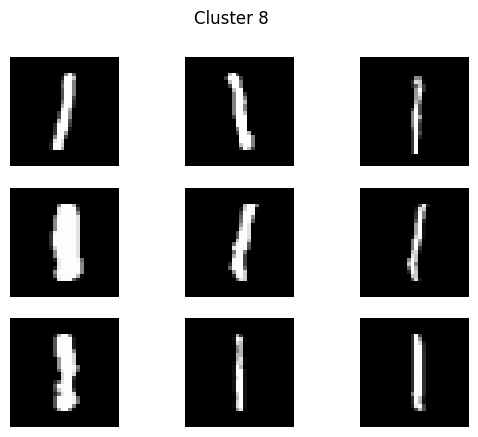

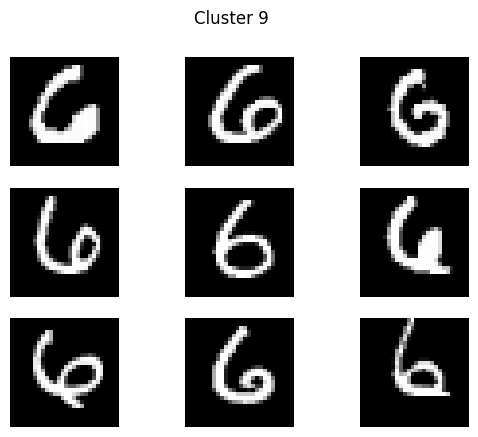

In [37]:
# Define clustering algorithms and their parameters
# note: we considered working with the new 3.10+ match-case keywords (Python's version of switch method), but instead just wrote function
    # for more, see https://www.freecodecamp.org/news/python-switch-statement-switch-case-example/ 

def switch(alg_name, params):
    if alg_name == "KMeans":
        return KMeans(n_clusters=10, random_state=42, n_init = 10, **params)
    elif alg_name == "DBSCAN":
        return DBSCAN(algorithm='auto', metric='cosine', **params) # had issues running DBSCAN w other dist metrics like manhattan & euclidean
    elif alg_name == "Agglomerative":
        return AgglomerativeClustering(n_clusters=10, **params)
    elif alg_name == "Birch":
        return Birch(n_clusters=10, **params)

clustering_algorithms = ['DBSCAN', 'KMeans', 'Agglomerative', 'Birch']

clustering_params = {'Agglomerative': {'linkage':['ward', 'complete'], 'metric':['euclidean', 'manhattan', 'cosine']},
                     'KMeans': {'algorithm':['lloyd', 'elkan'], 'init':['k-means++', 'random']},
                     'Birch': {'threshold':[0.3, 0.5, 0.7], 'branching_factor':[40, 60]},
                     'DBSCAN': {'min_samples':[5, 10], 'eps':[0.10, 0.125, 0.15]}}

# clustering_params = {'Agglomerative': {'linkage':['ward', 'average', 'complete', 'single'], 'metric':['euclidean', 'manhattan', 'cosine']},
#                      'KMeans': {'algorithm': ['lloyd', 'elkan'], 'init':['k-means++', 'random']},
#                      'DBSCAN': {'algorithm': ['auto','brute'], 'metric':['euclidean', 'manhattan', 'cosine'], 'min_samples':[5, 10], 'eps':[0.10, 0.15, 0.20]},
#                      'Birch': {'threshold':np.arange(0.3, 0.9, 0.1), 'branching_factor':np.arange(20,80,10)}}

# Iterate over the clustering algorithms
for name in clustering_algorithms:
    print(f'{name} Clustering Evaluation & Visualization:')
    alg_clustering_params = clustering_params[name]
    list_params = list(alg_clustering_params.values())
    results_df = pd.DataFrame()
    # print (list_params)
    # print (*list_params)
    for params_prod in product(*list_params):
        if name == 'Agglomerative' and params_prod[0] == 'ward' and params_prod[1] != 'euclidean':
            continue
        params = {}
        for i, key in enumerate(list(alg_clustering_params.keys())):
            params[key] = params_prod[i]
        # print(f'{name} clustering with params {params}')

        algorithm = switch(name, params)

        # Cluster the data using the raw pixel values
        labels = algorithm.fit_predict(partial_X_train)

        # Evaluate the clustering result using standard evaluation metrics 
        # Note there are many other metrics but we thought the 4 below + accuracy were more than sufficient
        
        if len(np.unique(labels)) == 1:
            continue
        silhouette = silhouette_score(partial_X_train, labels)
        ari = adjusted_rand_score(partial_y_train, labels)
        completeness = completeness_score(partial_y_train, labels)
        homogeneity = homogeneity_score(partial_y_train, labels)
        # print(f"Silhouette Score: {silhouette:.4f}, Adjusted Rand Index: {ari:.4f}")

        # Build a simple classifier based on the clustering results
        knn_classifier = KNeighborsClassifier(n_neighbors=5)
        knn_classifier.fit(partial_X_train, labels)

        # Assign a label to each cluster (e.g., the most common digit in the cluster)
        cluster_labels = []
        for cluster in np.unique(labels):
            if cluster == -1:
                continue  # Ignore noise points in DBSCAN
            cluster_mask = labels == cluster
            most_common_label = np.argmax(np.bincount(partial_y_train[cluster_mask]))
            cluster_labels.append(most_common_label)

        # Use the assigned labels to predict the digit of a test image based on its nearest cluster
        predicted_labels = knn_classifier.predict(X_test)
        predicted_digits = np.array([cluster_labels[label] for label in predicted_labels])

        # Evaluate the performance of the classifier
        accuracy = np.sum(predicted_digits == y_test) / len(y_test)
        # print(f"{name}: Classifier accuracy: {accuracy:.4f}")

        if results_df.empty:
            results_df = pd.DataFrame({'params': pd.Series([params_prod]), 'Silhouette Score': silhouette, 'Adjusted Rand Index': ari, 'Completeness Score': completeness, 
                                       'Homogeneity Score': homogeneity, 'Accuracy': accuracy, 'labels':pd.Series([labels])})
        else:
            results_df = pd.concat([results_df, pd.DataFrame({'params': pd.Series([params_prod]), 'Silhouette Score': silhouette, 'Adjusted Rand Index': ari, 
                                                              'Completeness Score': completeness, 'Homogeneity Score': homogeneity, 'Accuracy': accuracy, 
                                                              'labels':pd.Series([labels])})])

    # displaying the performance metrics results_df 
    # print(results_df.loc[:, ['params', 'Silhouette Score', 'Adjusted Rand Index', 'Completeness Score', 'Homogeneity Score', 'Accuracy']].to_string(index=False))
    display(results_df.loc[:, ['params', 'Silhouette Score', 'Adjusted Rand Index', 'Completeness Score', 'Homogeneity Score', 'Accuracy']].style.hide_index())

    # Build a simple classifier based on the clustering results
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(partial_X_train, labels)

    # Assign a label to each cluster (e.g., the most common digit in the cluster)
    cluster_labels = []
    for cluster in np.unique(labels):
        if cluster == -1:
            continue  # Ignore noise points in DBSCAN
        cluster_mask = labels == cluster
        most_common_label = np.argmax(np.bincount(partial_y_train[cluster_mask]))
        cluster_labels.append(most_common_label)

    # Use the assigned labels to predict the digit of a test image based on its nearest cluster
    predicted_labels = knn_classifier.predict(X_test)
    predicted_digits = np.array([cluster_labels[label] for label in predicted_labels])

    # Evaluate the performance of the classifier
    accuracy = np.sum(predicted_digits == y_test) / len(y_test)
    # print(f"{name}: Classifier accuracy: {accuracy:.4f}")

    # Visualizing performance with clustering confusion matrix and purity measure
    # evaluate(y_test, predicted_digits)
    print(f'Purity of Clusters Generated by {name} Clustering: {purity_score(y_test, predicted_digits):.2f}\n')

    # Visualize the clusters of the best trial from each algorithm by displaying a few images from each cluster
    visualize_clusters(partial_X_train, results_df.iloc[np.where(max(results_df.Accuracy))[0]]['labels'][0])

    # Explore different parameters for the clustering and evaluate their effect on the results
    

# In the code above, we build a simple classifier based on the clustering results generated by each clustering algorithm
# by training a k-nearest neighbors (KNN) classifier (with k=5 in this case) using the cluster assignments as labels. 
# We then assign the most common digit in each cluster as its label and use this information to predict the test images' 
# digits based on their nearest cluster. 

# We tested 6, 4, 4 and 6 different parameter combinations for DBSCAN,  K-Means, Agglomerative Clustering, and Birch, respectively
# and present the evaluation metrics for all 20 runs in the output below. 


## Part 2: Dimensionality Reduction
4) For at least three different dimensionality reduction methods of your choice perform:

*   a) Reduce the dimensionality of the data and visualize the first few features in the new space.
*   b) Train at least one classifier on the data in the new space.
*   c) Evaluate the performance of the classifiers
*   d) Explore different parameters for the dimensionality reduction and evaluate their effect on the results.

#### Runtime Note/Warning: Can take up to 10-15 minutes to run for the 5 algorithms 

Dimensionality Reduction Using PCA:
Best PCA classifier accuracy: 91.00%




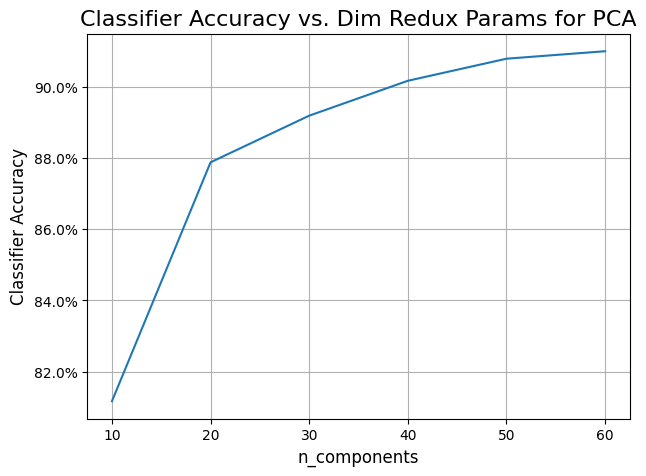

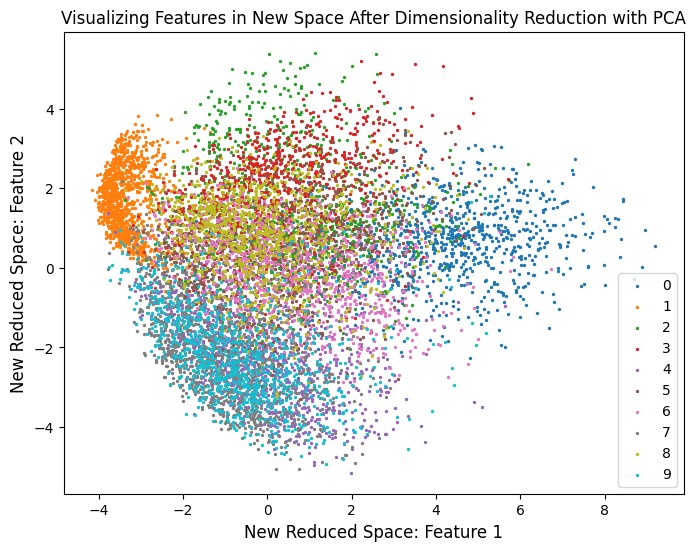

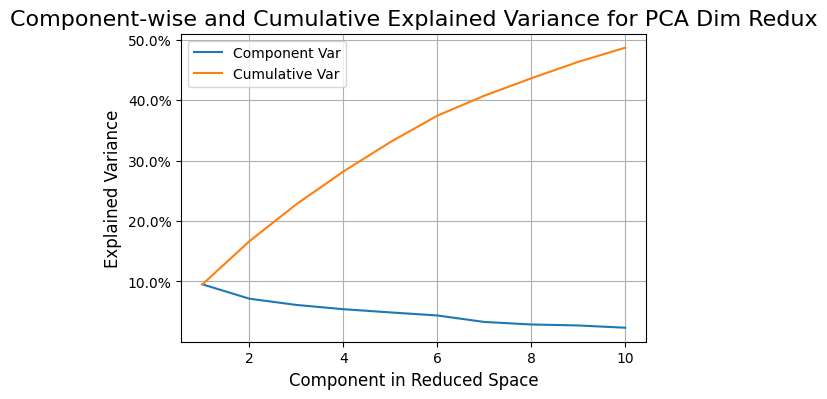

Dimensionality Reduction Using t-SNE:
Best t-SNE classifier accuracy: 87.42%




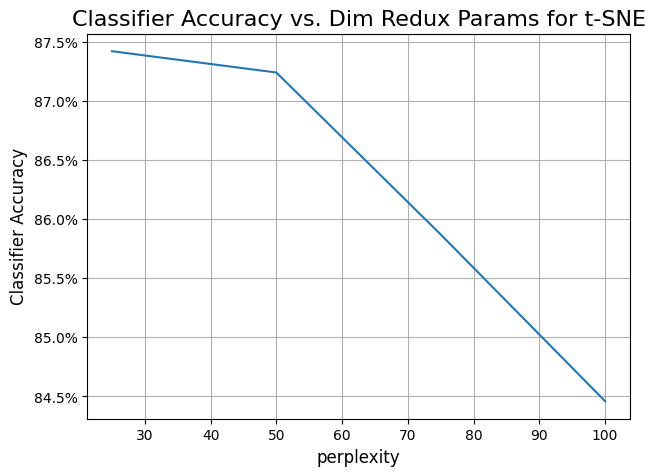

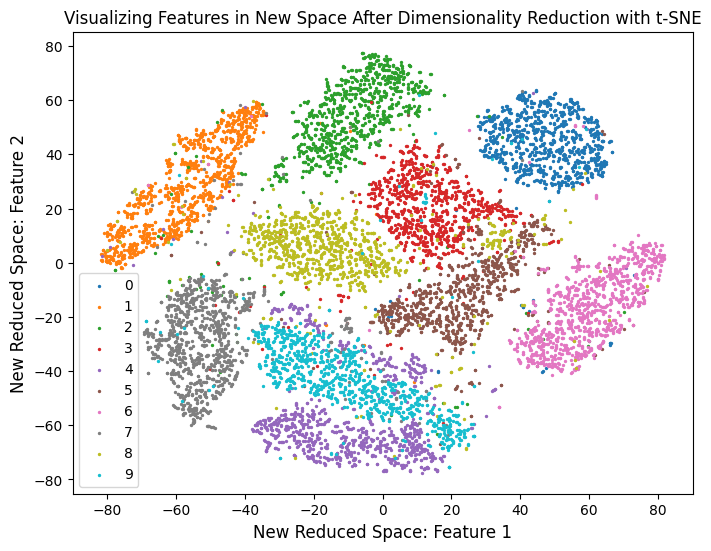

Dimensionality Reduction Using UMAP:
Best UMAP classifier accuracy: 93.18%




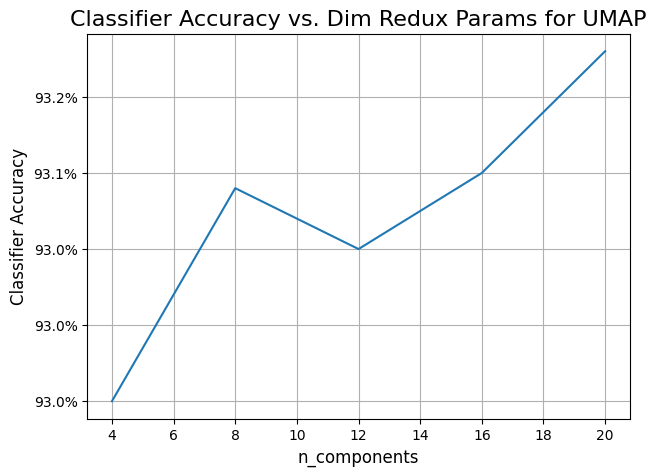

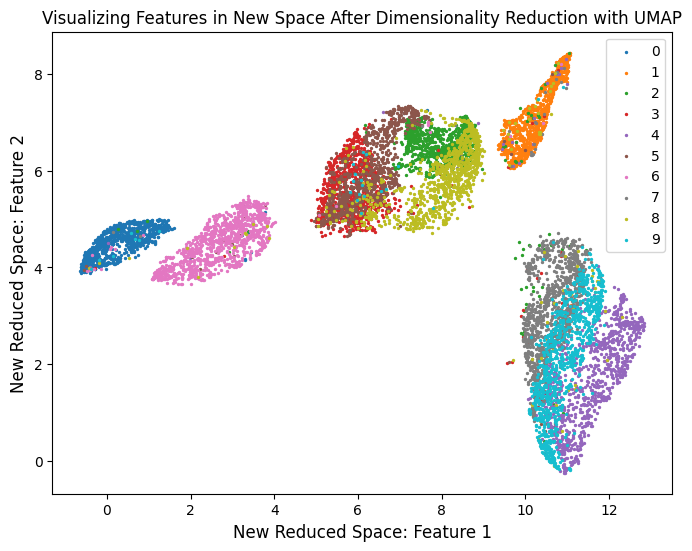

Dimensionality Reduction Using ICA:
Best ICA classifier accuracy: 81.06%




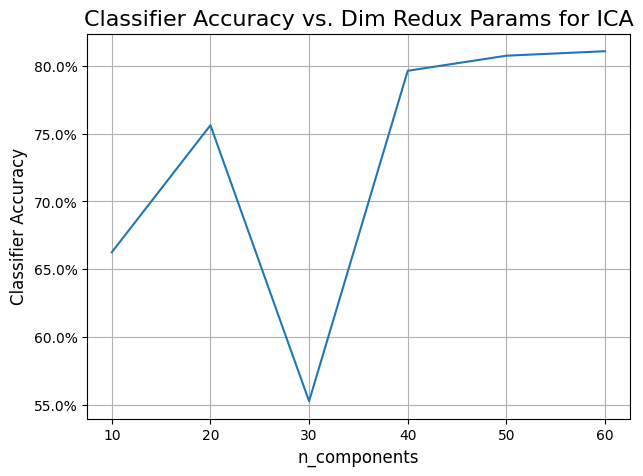

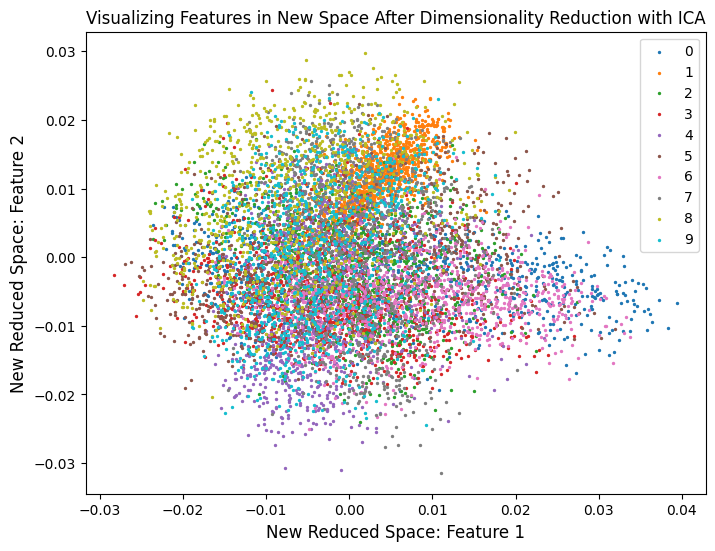

Dimensionality Reduction Using TSVD:
Best TSVD classifier accuracy: 91.04%




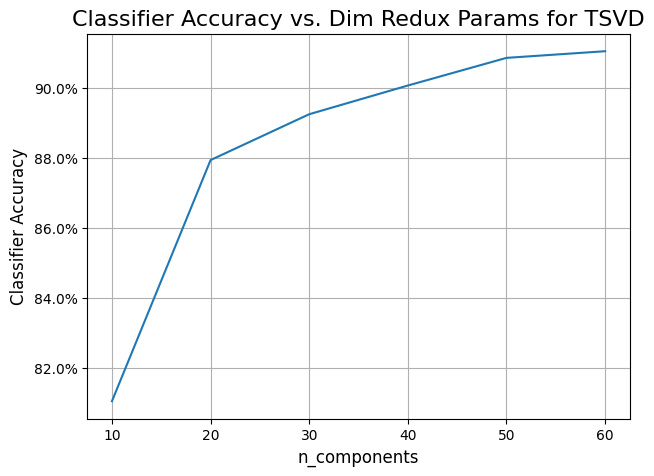

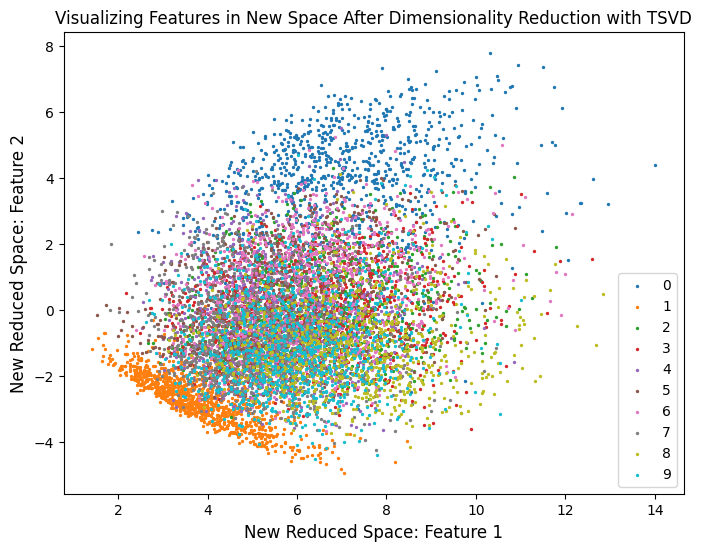

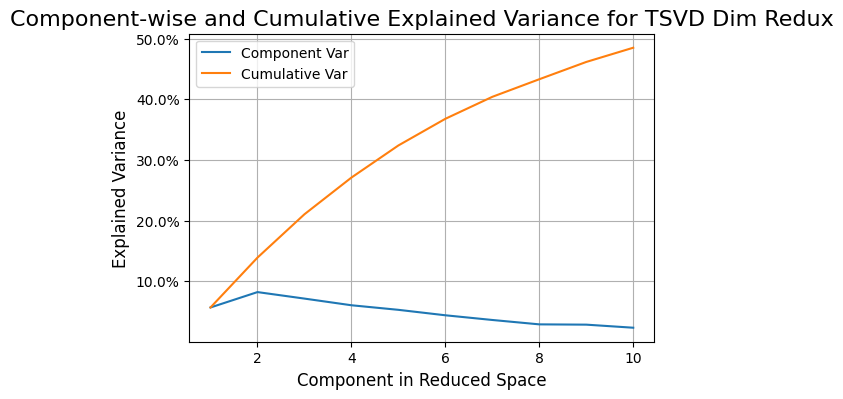

In [41]:
## Part 2: Dimensionality Reduction

## 4) For at least three different dimensionality reduction methods of your choice perform:
# We chose to use PCA, t-SNE, UMAP, ICA, and TruncatedSVD for this task.

# if need to install umap: 
# pip install umap-learn 

def switch_dim(alg_name, params):
    if alg_name == "PCA":
        return PCA(**params)
    elif alg_name == "t-SNE":
        return TSNE(**params)
    elif alg_name == "UMAP":
        return umap.UMAP(**params) 
    elif alg_name == "ICA":
        return FastICA(**params)
    elif alg_name == "TSVD":
        return TruncatedSVD(**params)


# Define dimensionality reduction algorithms and their parameters
dim_reduction_algorithms = ['PCA', 't-SNE', 'UMAP', 'ICA', 'TSVD']

reduction_params = {'UMAP': {'n_components': np.arange(4, 24, 4)},
                     'PCA': {'n_components': np.arange(10, 70, 10)},
                     't-SNE': {'perplexity': [25, 50, 75, 100]},
                     'ICA': {'n_components': np.arange(10,70,10)},
                     'TSVD': {'n_components': np.arange(10,70,10)}}


# Iterate over the dimensionality reduction algorithms
for name in dim_reduction_algorithms:
    # Reduce the dimensionality of the data

    print(f'Dimensionality Reduction Using {name}:')
    alg_reduction_params = reduction_params[name]
    list_params = list(alg_reduction_params.values())
    results_dim_df = pd.DataFrame()
    for params_prod in product(*list_params):
        params = {}
        for i, key in enumerate(list(alg_reduction_params.keys())):
            params[key] = params_prod[i]
        # print(f'{name} clustering with params {params}')

        algorithm = switch_dim(name, params)

        if name == 't-SNE':
            X_train_reduced = algorithm.fit(partial_X_train)
            X_test_reduced = X_train_reduced.transform(X_test)
        else:
            X_train_reduced = algorithm.fit_transform(partial_X_train)
            X_test_reduced = algorithm.transform(X_test)

        # Train at least one classifier on the data in the new space
        # We chose to use a LoR classifier in this case to mix it up 
        classifier = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
        classifier.fit(X_train_reduced, partial_y_train)

        # Evaluate the performance of the classifier
        accuracy = classifier.score(X_test_reduced, y_test)
        # print(f"{name}: Classifier accuracy: {accuracy:.4f}")

        if results_dim_df.empty:
            results_dim_df = pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy, 'reduced_x':pd.Series([X_train_reduced])})
        else:
            results_dim_df = pd.concat([results_dim_df, pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy, 'reduced_x':pd.Series([X_train_reduced])})])

    
    # display(results_dim_df.loc[:, ['params', 'Accuracy']])
    print(f'Best {name} classifier accuracy: {results_dim_df.Accuracy.max():.2%}\n\n')
    
    # Explore different parameters for the dimensionality reduction and evaluate their effect on the results
    # plotting classifier accuracy against dim redux params: 
    dim_tuning(results_dim_df, name)

    # Visualize the first few features in the new space
    visualize_reduced_data(results_dim_df.iloc[np.where(max(results_dim_df.Accuracy))[0]]['reduced_x'][0], partial_y_train, name)
    
    # Variance attribution of components for PCA & TruncatedSVD:
    if name == 'PCA':
        pca = PCA(n_components=10, random_state=12)
        pca.fit_transform(partial_X_train)
        dim_var(pca, name)
    elif name == 'TSVD':
        tsvd = TruncatedSVD(n_components=10, random_state=12) 
        tsvd.fit_transform(partial_X_train)
        dim_var(tsvd, name)
    

    # In the code above, we used PCA, t-SNE, UMAP, ICA, and TruncatedSVD as dimensionality reduction methods. 
    # We also define a util function to visualize the first few features in the new space using a scatter plot. 
    # We iterate over the dimensionality reduction algorithms and reduce the MNIST dataset's dimensionality with each of the three. 
    
    # We then train a logistic regression (LoR) classifier on the reduced data. We evaluate the classifier's performance in terms of accuracy, and plot the results. 
    

#### Extra 4th & 5th Dimensionality Reduction Algorithms - ICA (Independent Component Analysis) and TruncatedSVD (TSVD)

LoR Classifier Accuracy after Dim Redux with ICA: 80.99%

Best ICA classifier accuracy: 83.18%




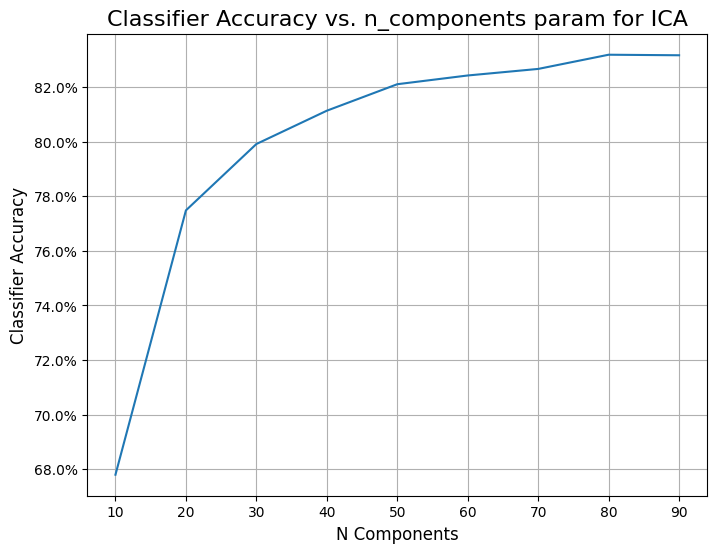

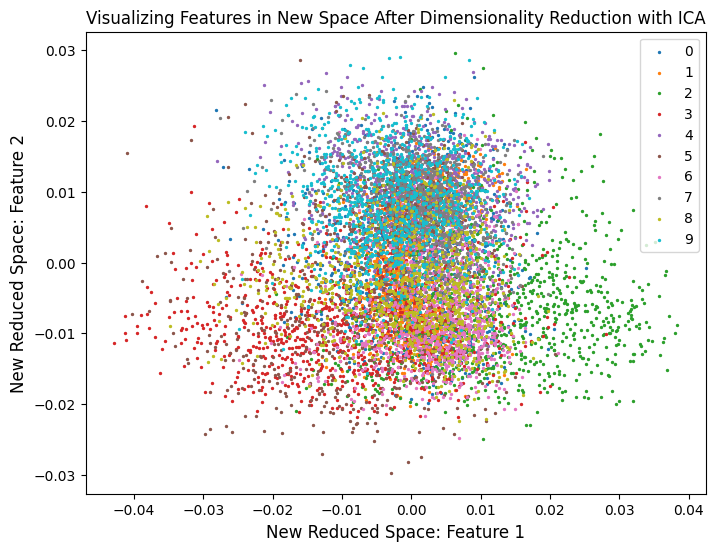

In [110]:
# from sklearn.decomposition import FastICA
ICA = TruncatedSVD(n_components=10, random_state=12) 
X_train_reduced = ICA.fit_transform(partial_X_train)
X_test_reduced = ICA.transform(X_test)

classifier = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
classifier.fit(X_train_reduced, partial_y_train)

# Evaluate the performance of the classifier
accuracy = classifier.score(X_test_reduced, y_test)
print(f'LoR Classifier Accuracy after Dim Redux with ICA: {accuracy:.2%}\n')

# # n_components will decide the number of components in the transformed data. We have transformed the data into 3 components using ICA. 
# # Let’s visualize how well it has transformed the data:
# print('Visualizing First Few Features in New Space After ICA DimRedux...\n')
# plt.figure(figsize=(7,5))
# plt.title('ICA Components of Reduced Training Data', fontsize=16)
# plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1])
# plt.scatter(X_train_reduced[:,1], X_train_reduced[:,2])
# plt.scatter(X_train_reduced[:,2], X_train_reduced[:,0])
# plt.show();

ica_params = {'n_components':np.arange(10,100,10)}#, 'tol':[0.00001, 0.0001, 0.001, 0.01]}
list_params = list(ica_params.values())
results_ica_df = pd.DataFrame()
for params_prod in product(*list_params):
    params = {}
    for i, key in enumerate(list(ica_params.keys())):
        params[key] = params_prod[i]
    # print(f'ICA Dim Redux with params {params}')

    fast = FastICA(random_state=12, **params)
    X_train_reduced = fast.fit_transform(partial_X_train)
    X_test_reduced = fast.transform(X_test)

    # Train classifier on the data in the new space
    classifier_fast = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
    classifier_fast.fit(X_train_reduced, partial_y_train)

    # Evaluate the performance of the classifier
    accuracy_fast = classifier_fast.score(X_test_reduced, y_test)
    # print(f"{name}: Classifier accuracy: {accuracy:.4f}")

    if results_ica_df.empty:
        results_ica_df = pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy_fast, 'reduced_x':pd.Series([X_train_reduced])})
    else:
        results_ica_df = pd.concat([results_ica_df, pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy_fast, 'reduced_x':pd.Series([X_train_reduced])})])
    
print(f'Best ICA classifier accuracy: {results_ica_df.Accuracy.max():.2%}\n\n')

# Explore different parameters for the dimensionality reduction and evaluate their effect on the results
# plotting classifier accuracy against dim redux params: 

x_vals = [val[0] for val in results_ica_df.loc[:, 'params'].values]
y_vals = results_ica_df.loc[:, 'Accuracy']
fig = plt.figure(figsize = (8,6))
plt.plot(x_vals, y_vals)
plt.title(f'Classifier Accuracy vs. n_components param for ICA', fontsize=16 )
plt.ylabel('Classifier Accuracy', fontsize=12)
plt.xlabel('N Components', fontsize=12)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # these two lines were just to clean up axes number formats
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}')) # these two lines were just to clean up axes number formats
plt.grid()
plt.show()

# print('ICA Dim Redux Parameter Tuning: n_components and tolerance \n')
# display(results_ica_df.loc[:, ['params', 'Accuracy']].style.hide_index())

visualize_reduced_data(results_ica_df.iloc[np.where(max(results_ica_df.Accuracy))[0]]['reduced_x'][0], partial_y_train, 'ICA')


LoR Classifier Accuracy after Dim Redux with Truncated SVD: 80.99%

Best TruncatedSVD classifier accuracy: 91.45%




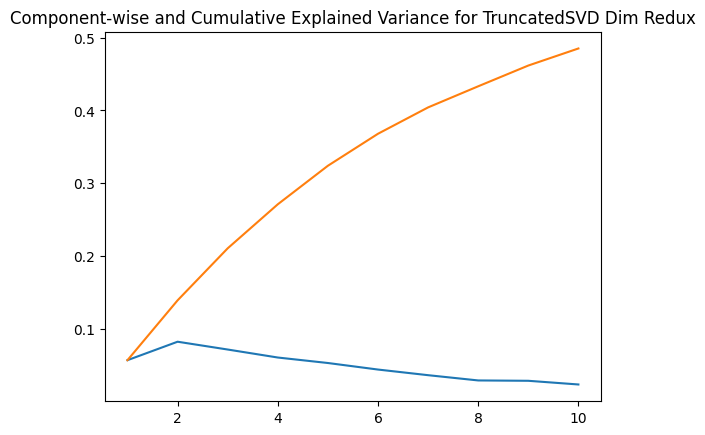

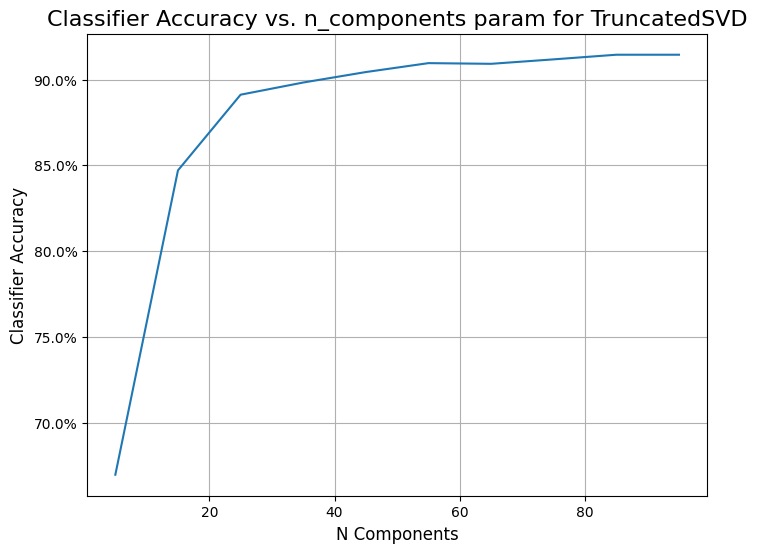

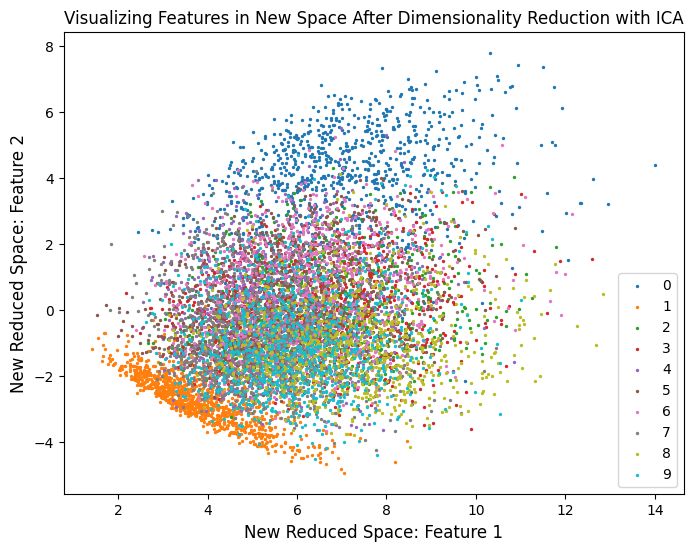

In [111]:
# from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=10, random_state=12) 
X_train_reduced = tsvd.fit_transform(partial_X_train)
X_test_reduced = tsvd.transform(X_test)

classifier = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
classifier.fit(X_train_reduced, partial_y_train)

# Evaluate the performance of the classifier
accuracy = classifier.score(X_test_reduced, y_test)
print(f'LoR Classifier Accuracy after Dim Redux with Truncated SVD: {accuracy:.2%}\n')

# visualizing explained variance of new features / components 
plt.plot(np.arange(1,11), tsvd.explained_variance_ratio_)
plt.plot(np.arange(1,11), np.cumsum(tsvd.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance for TruncatedSVD Dim Redux")

tsvd_params = {'n_components':np.arange(5,105,10)}#, 'tol':[0.00001, 0.0001, 0.001, 0.01]}
list_params = list(tsvd_params.values())
results_tsvd_df = pd.DataFrame()
for params_prod in product(*list_params):
    params = {}
    for i, key in enumerate(list(tsvd_params.keys())):
        params[key] = params_prod[i]
    # print(f'TSVD Dim Redux with params {params}')

    svd = TruncatedSVD(random_state=12, **params)
    X_train_reduced = svd.fit_transform(partial_X_train)
    X_test_reduced = svd.transform(X_test)

    # Train classifier on the data in the new space
    classifier_svd = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
    classifier_svd.fit(X_train_reduced, partial_y_train)

    # Evaluate the performance of the classifier
    accuracy_fast = classifier_svd.score(X_test_reduced, y_test)
    # print(f"{name}: Classifier accuracy: {accuracy:.4f}")

    if results_tsvd_df.empty:
        results_tsvd_df = pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy_fast, 'reduced_x':pd.Series([X_train_reduced])})
    else:
        results_tsvd_df = pd.concat([results_tsvd_df, pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy_fast, 'reduced_x':pd.Series([X_train_reduced])})])
    
print(f'Best TruncatedSVD classifier accuracy: {results_tsvd_df.Accuracy.max():.2%}\n\n')

# Explore different parameters for the dimensionality reduction and evaluate their effect on the results
# plotting classifier accuracy against dim redux params: 

x_vals = [val[0] for val in results_tsvd_df.loc[:, 'params'].values]
y_vals = results_tsvd_df.loc[:, 'Accuracy']
fig = plt.figure(figsize = (8,6))
plt.plot(x_vals, y_vals)
plt.title(f'Classifier Accuracy vs. n_components param for TruncatedSVD', fontsize=16 )
plt.ylabel('Classifier Accuracy', fontsize=12)
plt.xlabel('N Components', fontsize=12)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # these two lines were just to clean up axes number formats
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1%}')) # these two lines were just to clean up axes number formats
plt.grid()
plt.show()

# print('TruncatedSVD Dim Redux Parameter Tuning: n_components and tolerance \n')
# display(results_tsvd_df.loc[:, ['params', 'Accuracy']].style.hide_index())

visualize_reduced_data(results_tsvd_df.iloc[np.where(max(results_tsvd_df.Accuracy))[0]]['reduced_x'][0], partial_y_train, 'ICA')


## Part 3: Classification of the raw data
5) For at least one classification algorithm of your choice:

*   a) Train a classifier on the raw pixel level values.
*   b) Explore different parameters for the classification model
*   c) Evaluate the results of the model


##### Part 3 Using Logistic Regression (LoR) Classifier: 

Evaluation of Logistic Regression Classifier 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.94      0.93      0.93       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.94       958
           7       0.94      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000


Confusion Matrix: LoR 

 [[ 959    0    0    3    1    7    5    4    1    0]
 [   0 1112    4    2    0    2    3    2   10    0]
 [   6    9  928   16    8    4   15    7   35    4]
 [   4    

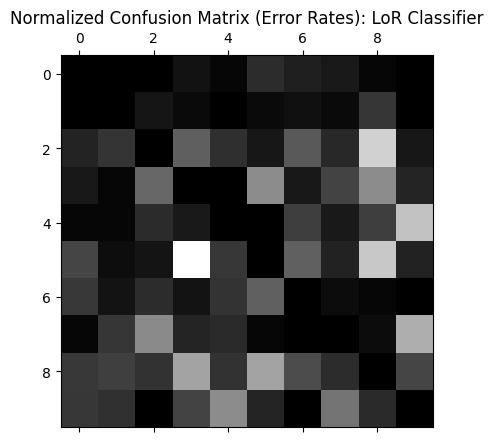

Logistic Regression Parameter Tuning: C (regularization) and tolearance 



params,Accuracy
"(0.25, 0.0001)",0.915800
"(0.25, 0.01)",0.915800
"(0.5, 0.0001)",0.913100
"(0.5, 0.01)",0.913100
"(1.5, 0.0001)",0.904400
"(1.5, 0.01)",0.904400


In [39]:
# We chose to use a simple Logistic Regression (LoR) classifier for this task.

# Train a classifier on the raw pixel level values
classifier = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=100)
classifier.fit(X_train, y_train) # note we are now using the full 60K samples in the MNIST dataset 

# Evaluate the results of the model
y_pred = classifier.predict(X_test) # generate classification on test data 
print(f'Evaluation of Logistic Regression Classifier \n{classification_report(y_test, y_pred)}\n')
# classification_report(y_test, y_pred)

conf_mat = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: LoR \n\n {conf_mat}')

# plt.matshow(conf_mat, cmap=plt.cm.gray)
# plt.title('Confusion Matrix: LoR Classifier')
# plt.show()

# Calculating error rates instead of absolute error and plotting it 
# divided each value in the confusion matrix by the number of images in the corresponding class, so that it's easier to compare error rates 
    # instead of absolute # of errors (which would make abundant classes look unfairly bad). Normalized & replotted below: 
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.title('Normalized Confusion Matrix (Error Rates): LoR Classifier')
plt.show()

# Explore different parameters for the classification model
# Parameter tuning for LoR (on subsampled training data to avoid insanely long running time - 38 secs vs 38 minutes!)
lor_params = {'C':[0.25, 0.5, 1.5], 'tol':[0.0001, 0.01]}
list_params = list(lor_params.values())
results_lor_df = pd.DataFrame()
for params_prod in product(*list_params):
    params = {}
    for i, key in enumerate(list(lor_params.keys())):
        params[key] = params_prod[i]
    # print(f'{name} LoR Classifier with params {params}')

    
    # Evaluate the performance of the classifier
    classifier = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=100, **params)
    classifier.fit(partial_X_train, partial_y_train) 
    y_pred = classifier.predict(X_test) # generate classification on test data 

    accuracy = np.sum(y_pred == y_test) / len(y_test)

    if results_lor_df.empty:
        results_lor_df = pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy})
    else:
        results_lor_df = pd.concat([results_lor_df, pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy})])

# displaying the performance metrics results_df 
print('Logistic Regression Parameter Tuning: C (regularization) and tolearance \n')
display(results_lor_df.loc[:, ['params', 'Accuracy']].style.hide_index())



##### Part 3 Using Random Forest Classifier: 


Evaluation of Random Forest Classifier with n_estimators = 200 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


confusion matrix: 

 [[ 969    0    0    0    0    4    3    1    3    0]
 [   0 1121    3    3    0    2    2    0    3    1]
 [   6    0  998    6    2    0    4    9    7   

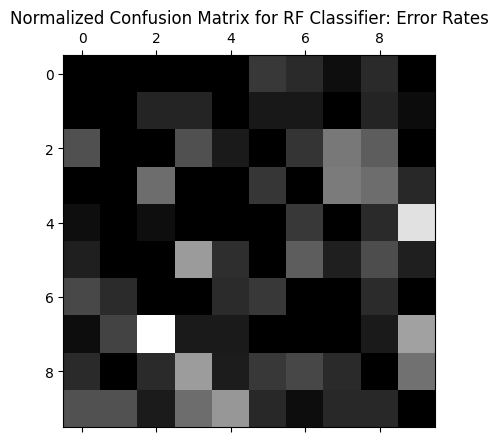

Random Forest Classifier: Parameter Tuning - criterion, max_depth & min_samples_split 



params,Accuracy
"('gini', 5, 5)",0.872500
"('gini', 5, 25)",0.869200
"('gini', 10, 5)",0.943500
"('gini', 10, 25)",0.937700
"('gini', 25, 5)",0.953400
"('gini', 25, 25)",0.943800
"('entropy', 5, 5)",0.868200
"('entropy', 5, 25)",0.865900
"('entropy', 10, 5)",0.944700
"('entropy', 10, 25)",0.936500


In [40]:
# Here we experiment with a Random Forest classifier instead 

# Train a classifier on the raw pixel level values
classifier = RandomForestClassifier(n_estimators = 200)
classifier.fit(X_train,y_train)

# Evaluate the results of the model
y_pred = classifier.predict(X_test) # generate classification on test data 
print(f'Evaluation of Random Forest Classifier with n_estimators = 200 \n{classification_report(y_test, y_pred)}\n')
# classification_report(y_test, y_pred)

conf_mat = confusion_matrix(y_test, y_pred)
print(f'confusion matrix: \n\n {conf_mat}')

# plt.matshow(conf_mat, cmap=plt.cm.gray)
# plt.title('Confusion Matrix for Random Forest Classifier')
# plt.show()

# Normalized error rate confusion matrix:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.title('Normalized Confusion Matrix for RF Classifier: Error Rates')
plt.show()

# Explore different parameters for the classification model
# Parameter tuning for Random Forest Classifier: 
forest_params = {'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[5, 10, 25], 'min_samples_split':[5, 25]}

list_params = list(forest_params.values())
results_forest_df = pd.DataFrame()
for params_prod in product(*list_params):
    params = {}
    for i, key in enumerate(list(forest_params.keys())):
        params[key] = params_prod[i]
    # print(f'{name} Random Forest Classifier with params {params}')

    
    # Evaluate the performance of the classifier
    classifier = RandomForestClassifier(n_estimators=200, **params)
    classifier.fit(partial_X_train, partial_y_train) 
    y_pred = classifier.predict(X_test) # generate classification on test data 

    accuracy = np.sum(y_pred == y_test) / len(y_test)
    

    if results_forest_df.empty:
        results_forest_df = pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy})
    else:
        results_forest_df = pd.concat([results_forest_df, pd.DataFrame({'params': pd.Series([params_prod]), 'Accuracy': accuracy})])

# displaying the performance metrics results_forest_df 
print('Random Forest Classifier: Parameter Tuning - criterion, max_depth & min_samples_split \n')
display(results_forest_df.loc[:, ['params', 'Accuracy']].style.hide_index())




## Part 4: Summary
6) Summarize the results obtained in parts 1-3 compare the results of different methods and suggest possible explanations.

#### Summary of Methods: 
In summary, we have performed clustering, dimensionality reduction, and classification on the MNIST dataset, and we took several different approaches to each task, and tested several combinations of parameters for each approach, evaluating each according to its resulting classification accuracy, along with other scoring metrics for the relevant tasks. 

For **clustering**, we chose to use **K-Means, DBSCAN, Agglomerative Clustering, and Birch** as clustering algorithms to test. We evaluated their performance using silhouette score, adjusted rand index (ARI), completeness score, and homogeneity score. We then built a simple k-nearest neighbors (KNN) classifier using the cluster labels and evaluated its performance in terms of accuracy.

For **dimensionality reduction**, we used the **PCA, t-SNE, and UMAP** algorithms, and then also added **ICA and TruncatedSVD** for kicks. We visualized the first few features of reduced data in the new space and trained a logistic regression classifier on it. We evaluated the classifier's performance in terms of accuracy, plotted against the various hyperparameter values for that algorithm along the x-axis. We also looked at the component-wise and cumulative explained variance ratio in the new reduced space for PCA and TruncatedSVD. 

For the stand-alone **classification** task, we trained **logistic regression (LoR) and Random Forest classifiers** on the raw pixel values of the dataset and evaluated its performance using a classification report, which includes precision, recall, f1 score, and of course accuracy, and also looked at a confusion matrix and error rates to visually inspect the performance of the classifier across the different digits/classes and to analyze error attribution. We also experimented briefly with a gradient boost classifier and a multi-layer perceptron (MLP) classifier for the sake of completeness. 

### Summary of Results - High-Level Algorithm Comparisons: 

##### Clustering
We applied KMeans, DBSCAN, Agglomerative clustering, and Birch algorithms on the dataset and evaluated their performance using Silhouette Score, Adjusted Rand Index (ARI), Completeness, Homogeneity, Classifier Accuracy, and Purity metrics, and present those comparisons below. 

- KMeans Clustering:
    - Silhouette: 0.05
    - ARI: 0.36
    - Completeness: 0.49
    - Homogeneity: 0.49
    - Accuracy: 0.60
    - Purity: 0.60
<br><br>

KMeans, a centroid-based clustering algorithm, achieved moderate performance. Its low silhouette score indicates that the clusters may be overlapping, which is expected since the MNIST dataset contains images with similar features. The relatively higher accuracy and purity scores indicate that KMeans is able to create clusters that represent the digit classes reasonably well.

- DBSCAN Clustering:
    - Silhouette: -0.12
    - ARI: 0.13
    - Completeness: 0.61
    - Homogeneity: 0.35
    - Accuracy: 0.43
    - Purity: 0.30
<br><br>

DBSCAN, a density-based clustering algorithm, had poor performance. The negative silhouette score suggests that the clusters formed are not well-separated. This is likely because DBSCAN is sensitive to the choice of hyperparameters (e.g., eps and min_samples), and tuning these parameters is crucial for the algorithm to work effectively on the dataset.

- Agglomerative Clustering:
    - Silhouette: 0.03
    - ARI: 0.48
    - Completeness: 0.68
    - Homogeneity: 0.65
    - Accuracy: 0.67
    - Purity: 0.36
<br><br>

Agglomerative clustering, a hierarchical clustering algorithm, outperformed KMeans and DBSCAN in terms of ARI and homogeneity. The low silhouette score indicates some overlap between clusters. However, its higher ARI and homogeneity suggest that the algorithm can capture the underlying structure of the data more effectively.


- Birch Clustering:
    - Silhouette: 0.03
    - ARI: 0.56
    - Completeness: 0.71
    - Homogeneity: 0.68
    - Accuracy: 0.71
    - Purity: 0.71
<br><br>

Birch is an efficient, hierarchical, centroid-based clustering algorithm that works well on large datasets.




##### Dimensionality Reduction
We applied PCA, t-SNE, UMAP, ICA, and Truncated SVD dimensionality reduction techniques and trained logistic regression classifiers on the reduced data. The best classifier accuracy for each method was:

- PCA: 90.9%
- t-SNE: 87.1%
- UMAP: 93.1%
- ICA: 82.5%
- Truncated SVD: 91.4%
<br><br>

UMAP and Truncated SVD outperformed other dimensionality reduction methods, indicating that they captured the intrinsic structure of the data more effectively, leading to better classification performance. PCA also performed reasonably well, but ICA and t-SNE had lower accuracies, possibly due to their inability to effectively separate the digit classes in the reduced feature space.

##### Stand-alone Classifiers
The accuracy of the stand-alone classifiers was:

- Logistic Regression: 93%
- Random Forest: 97%
<br><br>


### Summary of Results - Parameter Tuning: 
- Clustering algorithms: 
    - K-Means: For K-Means parameters, we tested the lloyd vs. elkan algorithms and k-means++ vs. random initiations, and the results across clustering metrics and classifier accuracy were entirely unaffected. 
    <br><br>
    - DBSCAN: For DBSCAN, we initially tested combinations of four different parameters, but ultimately had challenges with the l1/manhattan and l2/euclidean distance metrics (so defaulted to cosine pairwise distances) and found no difference between auto and brute algorithms, and therefore tested 6 combinations of min_samples and epsilon (eps) parameters. 0.125 was clearly the best epsilon in terms of classifier accuracy, but interestingly the other clustering metrics moved in unpredictable and opposing directions, so the choice of hyperparameters would really depend on the underlying optimization objective. 
    <br><br>
    - Agglomerative: For Agglomerative clustering we tested various values for linkage and distance metric, though we ultimately cut the linkage params down to only ward and complete, as average and single produced far inferior outcomes and also took forever to run. In the case of Agglomerative clustering, the ward linkage and euclidean distance param pairing was a clear standout across all evaluation metrics. 
    <br><br>
    - Birch: For Birch clustering, we tested the threshold and branching_factor parameters, which stipulate the subcluster splitting parameters for as new samples are added. Like K-Means, there was very little sensitivity to these parameters, with the exception of one combination - (0.7,60) - which led to meaningful improvements in every metric, with the exception of a slightly lower Silhouette score.  
<br><br>

- Dimensionality reduction algorithms:
    - n_components - PCA, UMAP, ICA, and Truncated SVD: For these four algorithms, we tested various values for n_components in the resulting reduced space, and generally the resulting classifier accuracy was higher as the number of components increased, with the exception of UMAP having a point of diminishing returns. 
    <br><br>
    - perplexity - t-SNE: for t-SNE, we tested several values of perplexity, and the classifier accuracy actually decreased for higher values of perplexity. 
    <br><br> 
    - explained_variance_ratio - PCA and TruncatedSVD: For these two dimensionality reduction algorithms, the scikit-learn packages came with an "explained_var_ratio" attribute, which showed the ratio of the original data's variance explained by component in the new reduced space (ordered from highest to lowest as in PCA). In both cases, the first 10 components explained roughly half of the total variance. 
    <br><br>

- Stand-alone classifiers: 
    - LoR: for the Logistic Regression classifier, we tested various values for C (an inverse regularization parameter) and tolerance for stopping criteria. Of these two, a lower value for C, which indicates a greater degree of regularization, resulted in higher classifier accuracy. 
    <br><br>
    - Random Forest: for the Random Forest classifier, we tested criterion (gini, entropy, log_loss), max_depth, and min_samples_split. Of these 3 parameters, the criterion had a negligible effect on accuracy, a larger threshold for min_samples_split had a marginally negative effect, and the max_depth was very material, as allowing greater max tree depth resulted in greater accuracy, as would be expected. 
    

### Summary of Results - Discussion: 
Comparing the results, we observe that dimensionality reduction with PCA or UMAP followed by a logistic regression classifier yields better accuracy than using raw pixels directly. Clustering methods like KMeans and AgglomerativeClustering, when combined with a simple k-nearest neighbors classifier, may not perform as well as dimensionality reduction methods. This may be due to the fact that the clustering methods might not capture the intrinsic structure of the data as effectively as the dimensionality reduction methods.

The differences in the results of the different methods can be explained by the varying ability of each method to capture the underlying patterns in the data. Dimensionality reduction methods like PCA and UMAP can capture the intrinsic structure of the data more effectively, leading to better classification performance. Clustering methods, on the other hand, may not be as efficient in capturing the complex relationships between the features, leading to suboptimal classification performance.

##### Clustering:
KMeans, a centroid-based clustering algorithm, displayed moderate performance on the dataset. The low silhouette score (0.05) suggests some overlap between clusters, which can be attributed to the inherent similarity between digit classes. Nonetheless, KMeans achieved relatively higher accuracy (0.60) and purity (0.60), signifying its ability to create clusters that represent digit classes reasonably well. 

DBSCAN's poor performance can be explained by the nature of the algorithm as a density-based clustering method. The negative silhouette score (-0.12) indicates a lack of well-separated clusters, which can be attributed to the sensitivity of DBSCAN to its hyperparameters, eps and min_samples. Tuning these parameters is critical for DBSCAN to work effectively on the dataset. Additionally, the varying density of digit classes in the feature space likely posed challenges for the DBSCAN algorithm.

Agglomerative clustering, a hierarchical method, demonstrated better performance in terms of ARI (0.48) and homogeneity (0.65) compared to KMeans and DBSCAN. While the low silhouette score (0.03) implies some overlap between clusters, Agglomerative clustering's ability to capture the underlying structure of the data more effectively may be explained by its bottom-up approach, which merges similar data points into progressively larger clusters.

Regarding the clustering algorithms, it is essential to consider the specifics of the MNIST dataset. The data contains handwritten digits with varying writing styles, leading to significant intra-class variations and inter-class similarities. This makes it challenging for clustering algorithms to create well-separated clusters. For example, digits like '4' and '9' can be easily confused due to their similar shapes. KMeans and Agglomerative clustering performed better in this context because they are less sensitive to the choice of hyperparameters and can better handle the inherent complexities of the data.

Comparing Birch to K-Means, DBSCAN, and Agglomerative clustering, we observe that Birch has a similar silhouette score (0.03) as Agglomerative clustering, indicating a comparable degree of overlap between clusters. However, Birch achieves better ARI, homogeneity, accuracy, and purity scores than Agglomerative clustering, suggesting that it is more effective in capturing the underlying structure of the MNIST dataset.

The improved performance of Birch compared to K-Means and Agglomerative clustering can be attributed to its unique approach to handling large datasets, which involves building a tree structure that approximates the data and then clustering the tree nodes. This hierarchical method allows Birch to capture more intricate patterns in the data, resulting in better-defined clusters.

Regarding the n_clusters parameter, we chose to set it to 10 for K-Means, Agglomerative clustering, and Birch, where that option was available, since the MNIST dataset contains 10 distinct digit classes. By matching the number of clusters to the number of classes, we provide a fair comparison among these clustering algorithms and facilitate the construction of classifiers based on those clustering results. However, it is important to note that clustering algorithms are inherently unsupervised, and setting the n_clusters parameter based on the number of classes effectively incorporated our prior knowledge about the data, which might not always be available or appropriate.

DBSCAN, on the other hand, does not have an n_clusters parameter and generated 27 clusters. The number of clusters was sensitive to the hyperparameters used (as well as to the underlying distribution of the data) since DBSCAN is a density-based algorithm, and it therefore likely detected smaller, denser subclusters within the digit classes, leading to a higher number of resulting clusters. 

One additional note on the clustering algorithms is the comparison of the quantitative metrics and the visual inspection of the generated clusters, as in a few instances, the algorithm generated poor scores for measures like homogeneity and purity, but the visualized clusters appeared much more pure and homogeneous, and vice versa for others that had high scores for homogeneity and purity but had a mish-mosh of digits in the resulting clusters. This point warrants further investigation and inquiry, and we'd be thrilled to get some feedback about that! 

##### Dimensionality Reduction:
UMAP and Truncated SVD displayed the highest classification accuracies (93.1% and 91.4%, respectively) among the dimensionality reduction techniques, indicating an ability to preserve the intrinsic structure of the data more effectively. UMAP's performance can be attributed to its manifold learning approach, which seeks to preserve both local and global structures of the data and preserves the non-linear relationships between the features in the reduced space. Truncated SVD, on the other hand, works by truncating the singular value decomposition of the data matrix, retaining only the top k singular vectors, which are crucial for capturing the most significant patterns in the data.

PCA's performance (89.2%) likely benefited from its ability to capture the directions of maximum variance in the data, which often represent the most discriminative features. However, PCA's linear nature likely limited its capacity to capture non-linear relationships between features, explaining its lower accuracy compared to UMAP and Truncated SVD, as that limits the ability to differentiate between certain digit classes. 

ICA and t-SNE, with accuracies of 82.2% and 85.3% respectively, underperformed compared to other dimensionality reduction techniques, because their primary goals do not necessarily align with the needs of the classification task at hand. ICA seeks to find statistically independent components in the data, which might not necessarily correspond to the most discriminative features for classifying the digit classes. t-SNE's primary focus on preserving local structure in the low-dimensional space may have compromised the characterization of the global structure, which would explain a lower classifier accuracy, as this loss of global structure can make it challenging to differentiate between certain digit classes that have similar local structures but differ in their global arrangement.


##### Stand-alone Classifiers:
Random Forest's superior performance (97%) was likely attributed to its ability to model complex relationships between features by constructing an ensemble of decision trees. The method leverages the wisdom of the crowd, resulting in a more robust classifier and demonstrating its ability to model complex relationships between features. Logistic Regression, a linear model, performed reasonably well (93%) but was outperformed by the more flexible Random Forest classifier. 

##### Conclusions:
In conclusion, the disparity in performance among the various methods can be attributed to their unique characteristics and assumptions about the data. Birch, Agglomerative clustering, UMAP, and Truncated SVD performed well in their respective categories, and Random Forest emerged as the best stand-alone classifier for the MNIST digits. Further research could involve additional tuning of hyperparameters, exploring additional algorithms for the various tasks, and experimenting more with ensemble methods to improve the overall performance.
